<a href="https://colab.research.google.com/github/Scherzan/Hello-World/blob/master/Notebook_Information_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pattern recognition, anomaly detection & prediction of energy consumption

## 1.Introduction
Nowadays more and more buildings use through smart home smart meters to get an insight of their energy consumption. Based on smart home technologies devices can be controlled remotely, and activities reported. It increases the home comfort, energy efficiency and security of house members. For example, the function of remote controlling devices fulfills all of the above-mentioned points. On the one hand, setting sets of rules such that water gets boiled before the house members wake up can increases the home comfort. On the other hand, it also increases the security and energy efficiency because devices can be accessed remotely which enables it for example to shut on/off or adjust devices even if no one is in the house. Whereas according to EESI (Energy Efficiency | EESI),  energy efficiency is using less energy to perform the same task. 
In this context we want to observe the household and try to improve the energy predictions by adding new features through pattern recognition and anomaly detection. With this background we want to explain methods such as clustering for pattern recognition, auto-encoders for anomaly detection and sequence-to-sequence long-short term memeory(LSTM) for energy prediction


### 1.1. Overview

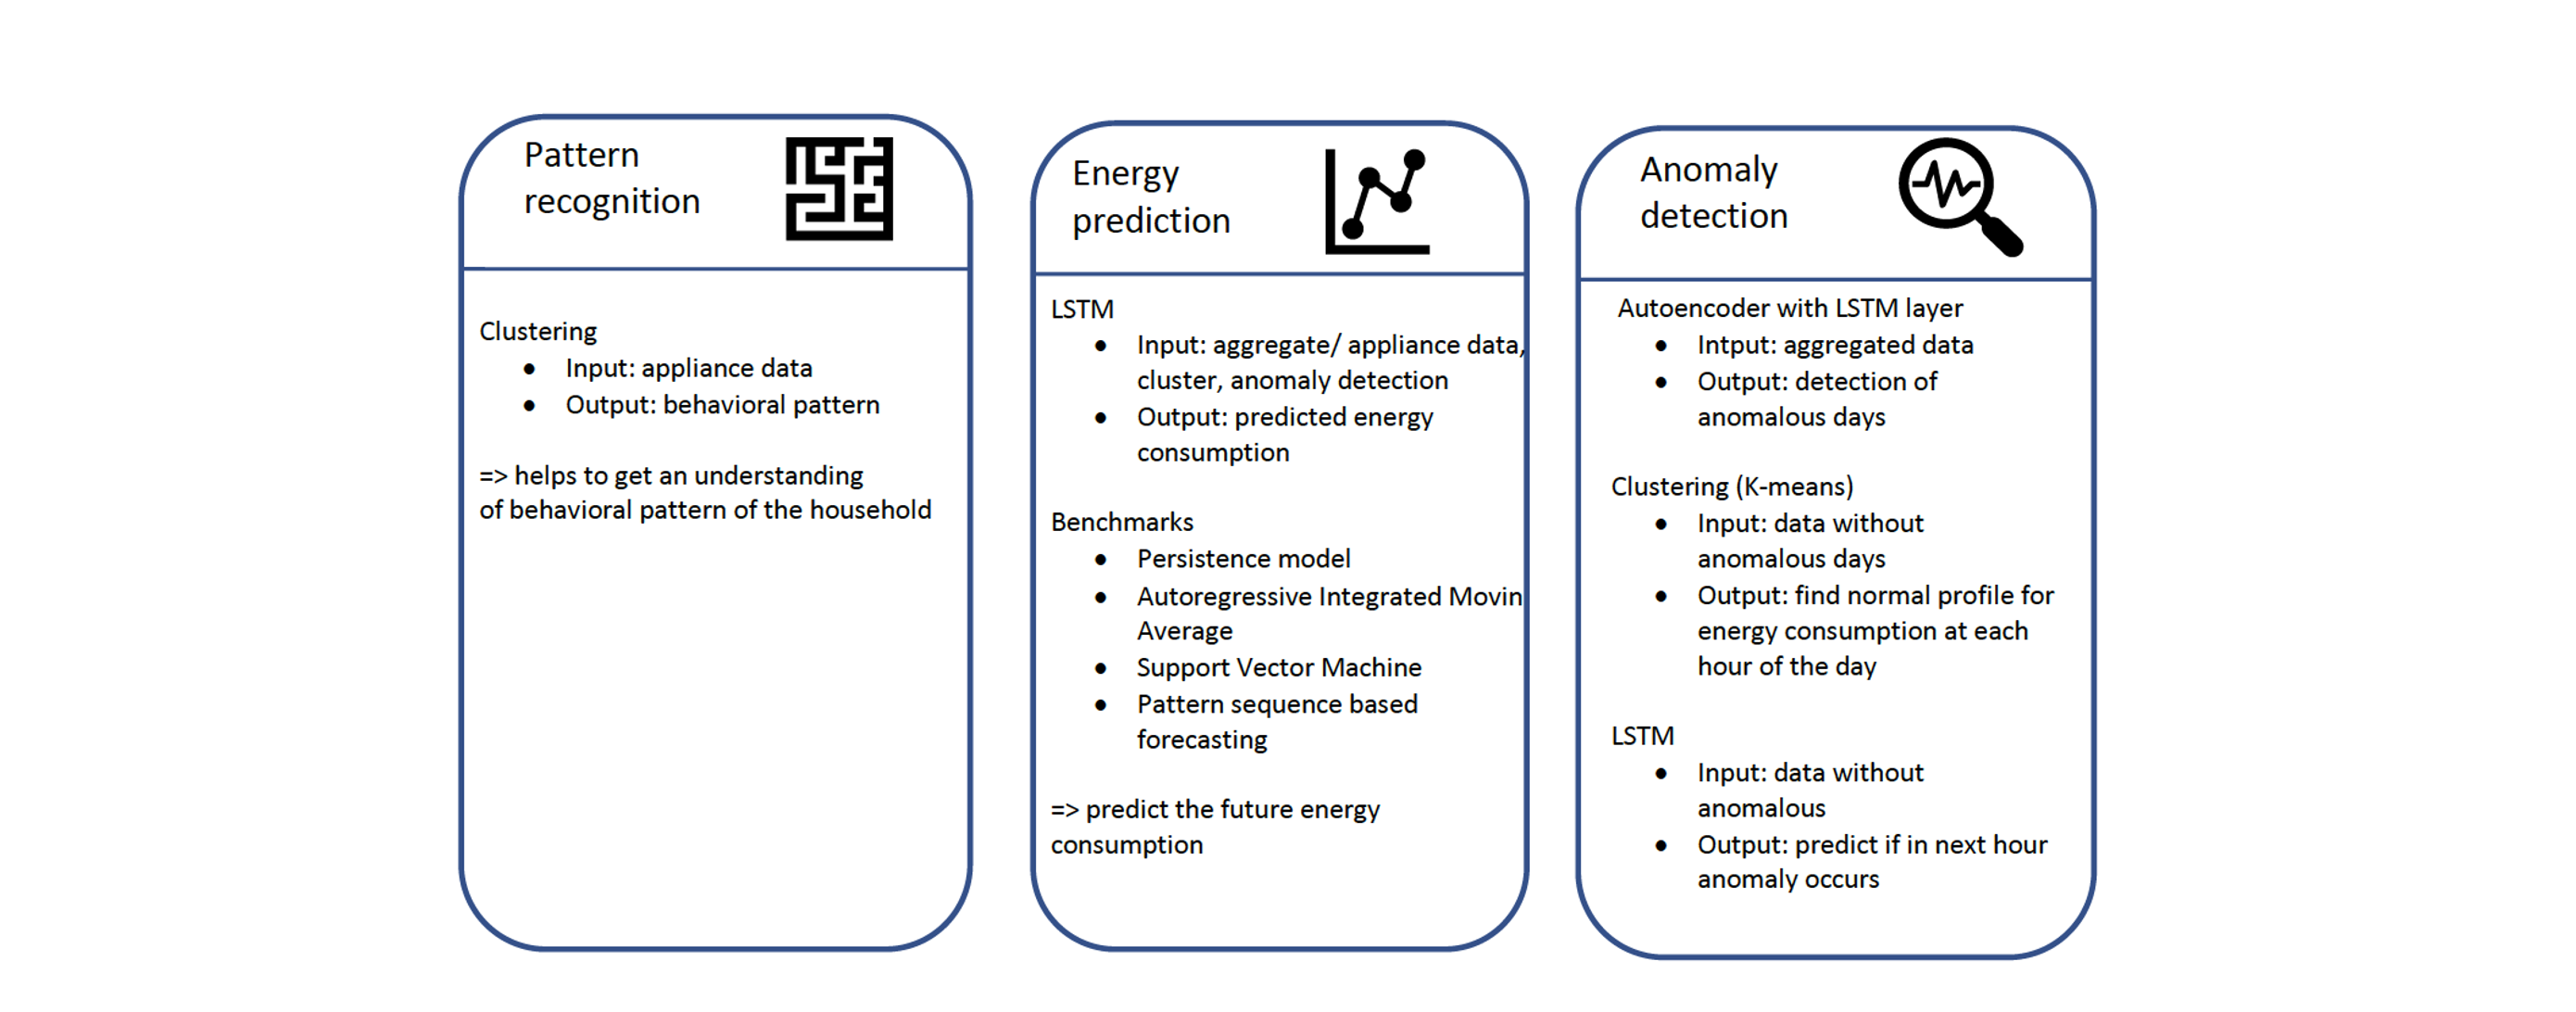

Figure 1.1 Overview

Based on the picture above we start with the pattern recognition where  clustering algorithms (k-Means) is used.
Clustering can group energy consumers into different customer groups based on there exist different household. In our case we have a look on whether we can differentiate between different behaviors based on the aggregate energy consumption within a specific time period.
For this clustering we used the k-means clustering approach. For energy prediction we decided to use the LSTM model because it can handle time series data. To improve the accuracy of the model we integrate additional features such as results of clustering and anomaly detection. To compare the results whether the output improved with clustering and anomaly detection we compare tem with results from severl benchmark models. 
To gain the predictions whether in the next hour anomalies occur or not we used several methods such as Clustering, Autoencoder and LSTM. Where the autoencoder detect the anomalous days and the clustering can extract the normal behaviour of the specific hour by removing them. At the end the LSTM forecasts if an anomaly will be occur in the specific hour or not.

### 2. Data
The data we used is the DRED data which monitors various parameters of one household in the Netherlands for six months from the 5th July until 5th December in 2015. The data gives information about the ambient, occupancy of people, household information and usage of electricity. For our task we mainly used the appliance level consumption data which consist of the time and the energy consumption of several appliances (television, fan, fridge, laptop computer, electric heating element, oven, blender, washing machine, microwave, toaster, sockets and cooker). Thereby the data is recorded in 1 second time intervals. Even though in many papers dataset with many households are used we decided to use the DRED dataset from 01.08.2015 to 30.09.2015 which contains only of one household because the behavior of the household can be observed more easily, and the amount of observations are more lucid. However, using only one household has also drawbacks such that the results of clustering would lead to other results because there are more possibilities for variables to cluster on. 
To progress further with the data, we preprocessed and cleaned the data by removing the missing values, adjust the datatype of the date and group the data to time intervals of 10 minutes. We truncate the information from time data about the UTC time offsets because we assume that this time changes do not affect and move the energy consumption in time, e. g. a member of a household who works every day in a given hour will not change their lifestyle and appliance usage because they still have to wake up at the same time because work begins always at 9 a.m. no matter the time offset is.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns 
import matplotlib.pyplot as plt

# Create a global variable to idicate whether the notebook is run in Colab
import sys
IN_COLAB = 'google.colab' in sys.modules

# Configure variables pointing to directories and stored files 
if IN_COLAB:
    # Mount Google-Drive
    from google.colab import drive
    drive.mount('/content/drive')
    DATA_DIR =   '/content/drive/MyDrive/IS Group3 Files/data/DRED/' #'/content/drive/MyDrive/IS Group3 Files/data/DRED/'

else:
    DATA_DIR = 'enter the name of your local drive' 

training_set = 'final_traindata.csv'  
test_set = 'final_testdata.csv'

apl_data = pd.read_csv(DATA_DIR + training_set)
test_data = pd.read_csv(DATA_DIR + test_set)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Loading the data and transforming the time column into datetime format takes a minute.  

In [ ]:
apl_data = apl_data.append(test_data)

# Function to get datetime format
def str_to_datetime(data):
    #delete last six characters from the Unnamed: 0 column with time as strings
    data = data[:-6]
    data = datetime.datetime.strptime(data, '%Y-%m-%d %H:%M:%S')
    return data

apl_data['time'] = apl_data['time'].apply(str_to_datetime)

# copy the dataframe for later detecting the anomalies
anomaly = apl_data.copy()

We also group our data on 60 minute timesteps such that it is easier to 
process. We will get the patterns for 60 min timesteps in this notebook to keep computation time within the models low. This required some of the preprocessing steps to be done in Pandas.

In [ ]:
apl_data = apl_data.groupby(pd.Grouper(key='time', freq='60min', level = None)).mean() 
apl_data.reset_index(inplace=True)


In [ ]:
def to_pattern(data):
    ''' Function to extract a list of pattern names 
      that are active at a given time step.
    '''

    appliances = ''
    
    for i in range(1,13):

        if (data.iloc[i]>0):
             appliances += data.index[i] + ', '
    
    return appliances[:-2]

apl_data['appl_pat'] = apl_data.apply(to_pattern, axis=1)

In [ ]:
def split_dataset(data, partition_point):
  '''
  The function divides a dataset at a given partition point 
  into a train, validation and test set. Validation and test 
  set length are each half the partition point.

  data:            dataset to be splitted
  partition_point: sum of rows in validation and test data 
  '''
	
  pp_half= int(partition_point/2) # half of rows after split for test
  train = data[0:-partition_point] 
  validation, test = data[-partition_point:-pp_half], data[-pp_half:]
  print(train.shape, validation.shape, test.shape)

  return train, validation, test

In [ ]:
full_train, full_val, full_test = split_dataset(apl_data, 672) #672h equal 28 days 

(2256, 14) (336, 14) (336, 14)


In [ ]:
knn_profile_train = full_train.copy()
knn_profile_test = full_val.append(full_test)

probabilities_train = full_train.copy()
probabilities_test = full_val.append(full_test)

## 2. Pattern recognition
There are several methods used for pattern recognition. The most common are Clustering, Classification and Frequent Pattern Mining. We tried out several methods and decided to go only with Clustering. 




### 2.1. K-means clustering for feature extraction

In our notebook we perform K-means clustering for feature extraction in order to classify the load during the day to a group as done in ('Understanding LSTM Networks'). It is used in finding groups that have not been explicitly labeled in our data. In the situation when whe want to classify the daily energy consumption into k groups, K-means comes in handy becuse it distinguishes types of daily load-profiles, for example it will create one cluster for the situation when there is almost no energy usage meaning that no one was at home or it will help us to see in which hours are the occupants not at home. We aggregate the data by time and create a new column for aggregated energy and then we apply a function to calculate this aggregated energy use.


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

knn_profile_train['time'] = pd.to_datetime(knn_profile_train['time'])
knn_profile_train['hour'] = knn_profile_train['date'] = knn_profile_train['aggregated_power'] = 0
knn_profile_train = knn_profile_train.groupby(pd.Grouper(key='time', freq='60min', level = None)).mean()


# create a list with the names of the appliances
columns = ['television', 'fan', 'fridge', 'laptop computer',
       'electric heating element', 'oven', 'blender', 'washing machine',
       'microwave', 'toaster', 'sockets', 'cooker']



#define the function that summs energy consumption for all of the appliances
def aggregate_appliances(data, x, y, z, i, e, o, p, r, s, t, q, a):


    aggregated_power = data[-1]

    aggregated_power = data[[x, y, z, i, e, o, p, r, s, t, q, a]].sum()
  

    return aggregated_power


appliance_power_locs = []

for i in columns: appliance_power_locs.append(full_train.columns.get_loc(i))

#apply the function that summs the energy consumption
knn_profile_train['aggregated_power'] = knn_profile_train.apply(aggregate_appliances, args=(appliance_power_locs), axis=1)


# stop

In [ ]:
knn_profile_train = knn_profile_train[['aggregated_power', 'hour', 'date']]
knn_profile_train = knn_profile_train.astype(np.float).fillna(method='bfill')


#knn_profile = knn_profile.resample('H').mean()
#knn_profile

knn_profile_train['hour'] = knn_profile_train.index.hour
knn_profile_train['date'] = knn_profile_train.index.date


#knn_profile
knn_profile_train.set_index('date', inplace = True)

# create a pivot table
knn_profile_pivot_train = knn_profile_train.pivot(columns='hour')
knn_profile_pivot_train = knn_profile_pivot_train.dropna()
knn_profile_pivot_train.columns = knn_profile_pivot_train.columns.droplevel()
knn_profile_pivot_train

hour,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
date,,,,,,,,,,,,,,,,,,,,,,,,
2015-08-01,69.978528,43.137039,37.394759,53.889590,42.770018,33.529312,36.621314,115.855186,165.506287,81.778601,139.975579,54.724372,47.310689,48.355576,33.514511,30.615081,41.653257,51.893500,40.508457,31.052949,440.806425,298.074064,114.124168,41.673529
2015-08-02,62.395521,53.702685,34.919093,47.725112,50.605899,35.202484,43.877841,56.298042,39.953165,106.141108,668.319306,160.012086,35.073969,59.873963,37.017731,41.389190,85.930749,289.820257,136.161478,33.932308,67.597834,86.477555,67.005585,91.192833
2015-08-03,83.421598,98.977783,79.553329,73.966764,83.764606,76.995131,42.307821,63.310215,71.012457,53.990847,151.910682,179.076256,116.416551,322.146066,79.852769,82.537268,69.604376,169.452685,67.273962,40.028651,58.133275,76.260667,64.477896,62.214537
2015-08-04,78.068382,39.745251,74.410276,87.382049,71.302624,75.538231,60.557792,56.973861,47.083178,408.015782,271.312057,355.832703,64.215704,287.664019,167.576681,102.198359,60.777679,35.493585,58.404551,32.587706,54.106242,138.858637,65.062637,66.880614
2015-08-05,61.005896,77.904614,84.207446,61.309004,47.449129,52.798687,57.470858,43.073667,87.575898,71.346874,59.590239,134.455830,51.775438,295.432708,77.262141,85.756030,92.521997,67.460532,55.772851,52.608863,132.561189,210.359424,86.983283,80.442286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-10-29,27.426815,35.474385,34.558382,30.891090,36.950072,40.986912,34.797653,53.389725,50.790624,5.457661,44.697551,29.025485,33.338687,34.720435,29.191094,34.432811,31.655926,33.118614,37.869623,39.226273,28.168325,39.063672,32.265060,47.828642
2015-10-30,48.915506,41.616950,49.977731,41.970542,35.698046,44.708045,57.871422,48.029622,18.085912,28.972217,44.698903,33.244913,30.332956,31.143757,32.055391,52.358585,37.891164,28.490058,36.397319,40.292017,19.623626,35.710192,37.614819,24.986851
2015-10-31,41.287306,51.945389,68.742029,17.736797,65.980560,54.249297,51.024604,21.763265,41.612460,38.551095,33.034397,32.470219,35.226794,28.593010,36.966449,38.811193,42.653429,35.879056,33.564167,34.399585,32.388401,34.768297,33.869326,43.501042


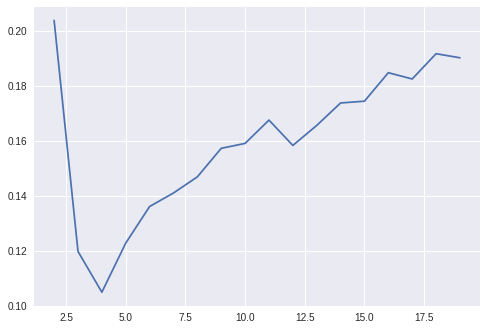

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score

sillhoute_scores = []
n_cluster_list = np.arange(2,20).astype(int)

X = knn_profile_pivot_train.values.copy()

# Very important to scale!
sc = MinMaxScaler()
X = sc.fit_transform(X)

for n_cluster in n_cluster_list:
    
    kmeans = KMeans(n_clusters=n_cluster, init='k-means++', max_iter=100, n_init=1, 
                               verbose=0,
                               random_state = 42)
    
    cluster_found = kmeans.fit_predict(X)
    
    sillhoute_scores.append(silhouette_score(X, kmeans.labels_))

plt.plot(n_cluster_list, sillhoute_scores);

Figure 2.2: Silhouette scores for 24 hours clusters

In the next step we select the needed columns and convert them to floats and aggregate for one hour. To the hour column we put the hour of the day and to the date column we put the actual date. In the end we set the index to date and create a pivot table where rows are represented by date and columns by hour of the day and the values are aggregated consumption. We drop one level of multiindex in columns names because we do not need it. 

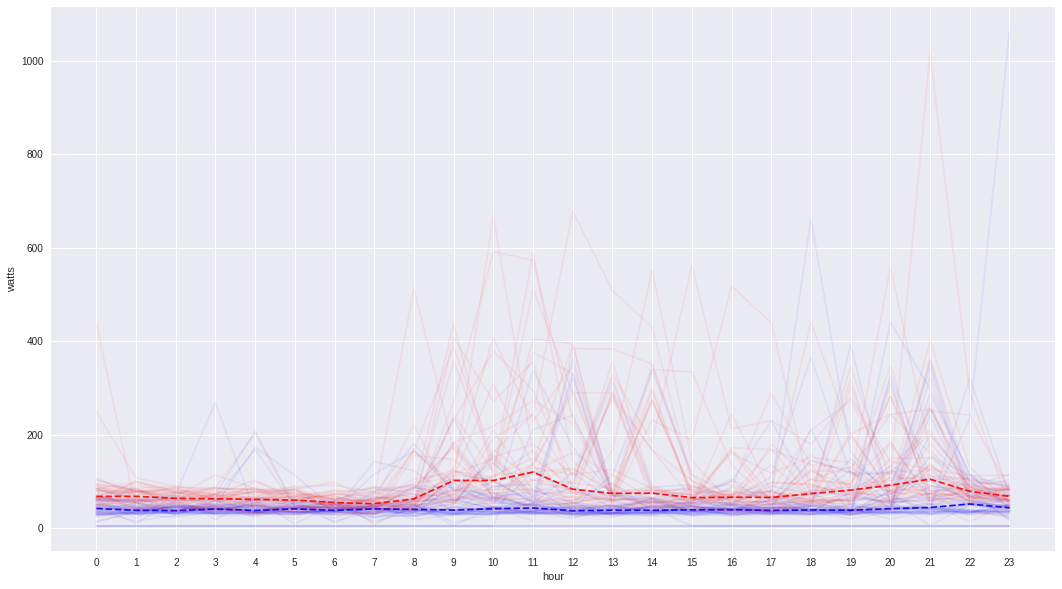

In [ ]:
number = 2
kmeans = KMeans(n_clusters=number, init='k-means++', max_iter=100, n_init=1, 
                               verbose=0,
                               random_state = 42)
cluster_found = kmeans.fit_predict(X)
cluster_found_sr = []
cluster_found_sr = pd.Series(cluster_found, name='cluster')

if isinstance(knn_profile_pivot_train.index, pd.MultiIndex):
    knn_profile_pivot_train.index = knn_profile_pivot_train.index.droplevel(level=1)
    knn_index_train =knn_profile_pivot_train.index.unique()
    knn_profile_pivot_train = knn_profile_pivot_train.set_index(cluster_found_sr, append=True)
else: 
    knn_index_train =knn_profile_pivot_train.index.unique()
    knn_profile_pivot_train = knn_profile_pivot_train.set_index(cluster_found_sr, append=True)
    
#save the dataframe to a csv data
frame_train = { 'date': knn_index_train, 'cluster': cluster_found_sr.values } 

result_profiles_train = pd.DataFrame(frame_train) 

fig, ax= plt.subplots(1,1, figsize=(18,10));
# for the number of clusters choose the colors in case of 2 only blue and red
color_list = ['blue','red','green', 'yellow', 'orange', 'brown', 'black', 'pink', 'purple', 'black'][0:number]

cluster_values = sorted(knn_profile_pivot_train.index.get_level_values('cluster').unique())

for cluster, color in zip(cluster_values, color_list):
    knn_profile_pivot_train.xs(cluster, level=1).T.plot(
        ax=ax, legend=False, alpha=0.06, color=color, label= f'Cluster {cluster}'
        );
    knn_profile_pivot_train.xs(cluster, level=1).median().plot(
        ax=ax, color=color, alpha=0.9, ls='--'
    );

ax.set_xticks(np.arange(0,24));
ax.set_ylabel('watts');
ax.set_xlabel('hour');

Figure 2.3: Energy consumption paths with cluster medians for 24 hours 

In [ ]:
cluster_data_train = result_profiles_train.rename(columns={'date' : 'day'})
full_train['day'] = full_train['time'].dt.date
full_train = pd.merge(full_train, cluster_data_train, on='day', how='left')
full_train.drop(columns=['day'], inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


**T-SNE Diagramms**


One can apply dimensionality reduction techniques to check the validity of our clustering algorithm. We plot our points on the 2 dimensional plane and color them according to the clusters they belong to. The algorithm that we are going to use to perform the dimensionality reduction is T-SNE. In contrast to PCA T-SNE can separate linearly inseparable points. 
In our case it is not aware of the clusters we created and that is why it is a good way to check whether our clusters were identified correctly. 
From the diagramm below we can that clusters identified by the KNN algorithm were also identified by the T-SNE






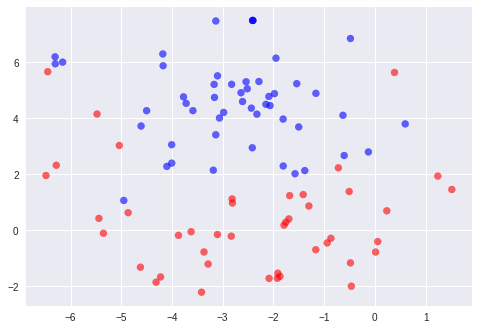

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.colors

tsne = TSNE()
results_tsne = tsne.fit_transform(X)

cmap = matplotlib.colors.LinearSegmentedColormap.from_list(cluster_values, color_list)


plt.scatter(results_tsne[:,0], results_tsne[:,1],
    c=knn_profile_pivot_train.index.get_level_values('cluster'),
    cmap=cmap, 
    alpha=0.6,
    );

Figure 2.4: T-SNE projection for 24 hours clusters

In [ ]:
# Equally prepare Test/validation data for cluster analysis
knn_profile_test['time'] = pd.to_datetime(knn_profile_test['time'])
knn_profile_test['hour'] = knn_profile_test['date'] = knn_profile_test['aggregated_power'] = 0
knn_profile_test = knn_profile_test.groupby(pd.Grouper(key='time', freq='60min', level = None)).mean()


appliance_power_locs = []

for i in columns: appliance_power_locs.append(knn_profile_test.columns.get_loc(i))

knn_profile_test['aggregated_power'] = knn_profile_test.apply(aggregate_appliances, axis=1, args=(appliance_power_locs))

knn_profile_test = knn_profile_test[['aggregated_power', 'hour', 'date']]
knn_profile_test = knn_profile_test.astype(np.float).fillna(method='bfill')

knn_profile_test['hour'] = knn_profile_test.index.hour
knn_profile_test['date'] = knn_profile_test.index.date

knn_profile_test.set_index('date', inplace = True)

# create a pivot table
knn_profile_pivot_test = knn_profile_test.pivot(columns='hour')
knn_profile_pivot_test = knn_profile_pivot_test.dropna()
knn_profile_pivot_test.columns = knn_profile_pivot_test.columns.droplevel()

### 2.2. Clustering for 6 hours

In [ ]:
knn_profile_train2 = knn_profile_train.copy()
knn_profile_train2['6-hour'] = 0
knn_profile_train2.loc[((knn_profile_train2['hour'] >= 0) & (knn_profile_train2['hour']<= 5)), '6-hour' ] = 1
knn_profile_train2.loc[((knn_profile_train2['hour'] >= 6) & (knn_profile_train2['hour']<= 11)), '6-hour' ] = 2
knn_profile_train2.loc[((knn_profile_train2['hour'] >= 12) & (knn_profile_train2['hour']<= 17)), '6-hour' ] = 3
knn_profile_train2.loc[((knn_profile_train2['hour'] >= 18) & (knn_profile_train2['hour']<= 23)), '6-hour' ] = 4
len_frame = len(knn_profile_train2)
if len_frame%6 <=3:
  sequence = np.tile(A = [1,2,3,4,5,6], reps = round(len_frame/6) + 1)
else:
  sequence = np.tile(A = [1,2,3,4,5,6], reps = round(len_frame/6) )

knn_profile_train2['hour'] = sequence[0:(len_frame)]



In [ ]:
knn_profile_train2.set_index('6-hour',append=True, inplace=True) 

knn_profile_train2

knn_profile_pivot_train2 = knn_profile_train2.pivot(columns='hour')

knn_profile_pivot_train2 = knn_profile_pivot_train2.dropna()

knn_profile_pivot_train2.columns = knn_profile_pivot_train2.columns.droplevel()
knn_profile_pivot_train2

hour                       1           2  ...           5          6
date       6-hour                         ...                       
2015-08-01 1       69.978528   43.137039  ...   42.770018  33.529312
           2       36.621314  115.855186  ...  139.975579  54.724372
           3       47.310689   48.355576  ...   41.653257  51.893500
           4       40.508457   31.052949  ...  114.124168  41.673529
2015-08-02 1       62.395521   53.702685  ...   50.605899  35.202484
...                      ...         ...  ...         ...        ...
2015-11-01 4       38.186786   26.997062  ...   50.288978  37.345560
2015-11-02 1       14.523944   34.441769  ...   48.065244  44.380705
           2       56.865528   29.442217  ...   35.184640  29.858054
           3       34.192610   32.258009  ...   25.122654  44.172863
           4       35.564207   19.809891  ...   38.780050  36.350654

[376 rows x 6 columns]

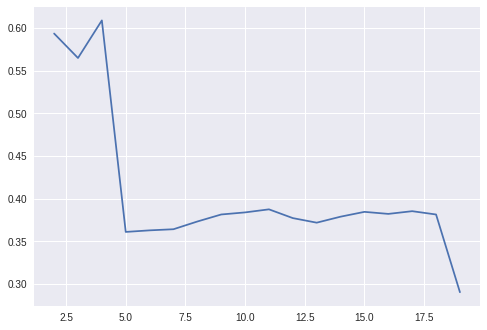

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score

sillhoute_scores = []
n_cluster_list = np.arange(2,20).astype(int)

X = knn_profile_pivot_train2.values.copy()
# Very important to scale!


sc = MinMaxScaler()
X = sc.fit_transform(X)
#X_test = sc.fit_transform(X_test)

for n_cluster in n_cluster_list:
    
    kmeans = KMeans(n_clusters=n_cluster, init='k-means++', max_iter=100, n_init=1, 
                               verbose=0,
                               random_state = 42)
    cluster_found = kmeans.fit_predict(X)
    sillhoute_scores.append(silhouette_score(X, kmeans.labels_))

plt.plot(n_cluster_list, sillhoute_scores);


Figure 2.5: Silhouette scores for 6 hours clusters

Feature extraction is an unsupervised method of machine learning. With the help of K-means algorithm we want to find day energy consumption profiles. We first scale our data and then with the help of Silhouette metric we decide to choose only two consumption profiles - clusters - besauce as seen in the figure 2.5 after two clusters Silhouette is falling down and then it is gradually rising. Since we do not have many day profiles in our data it is the best ot keep the number of clusters simple and small. 


So we train again our K-Means for two clusters and put the cluster labels into 
a dataframe. In the end we plot all of the daily profiles of the energy consumption for each day and the cluster median as presented in Figure 2.6.
If we decided to have more clusters it would be also possible.

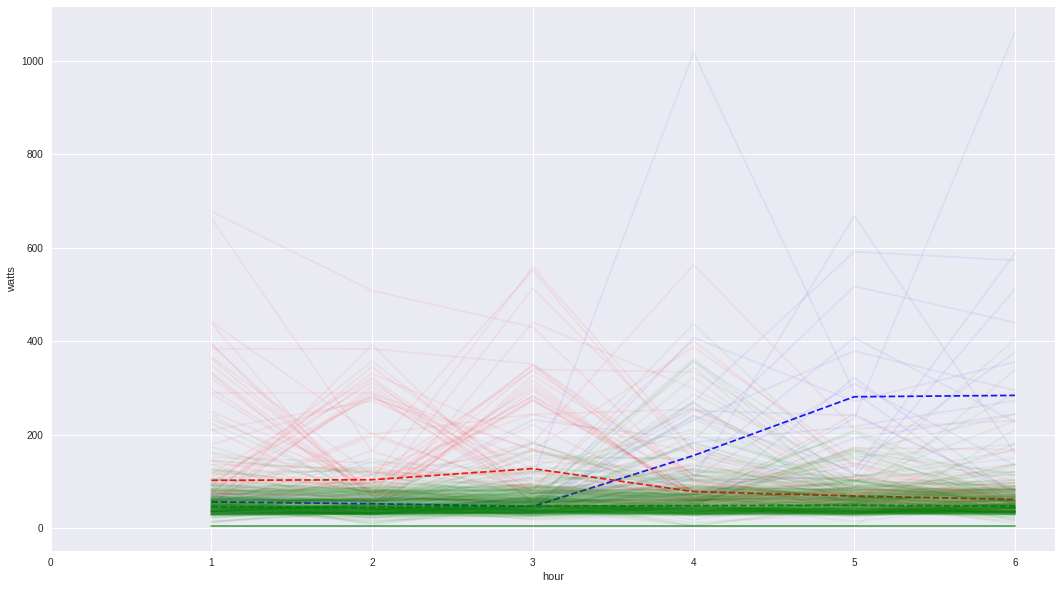

In [ ]:
number = 3
kmeans = KMeans(n_clusters=number, init='k-means++', max_iter=100, n_init=1, 
                               verbose=0,
                               random_state = 42)
cluster_found = kmeans.fit_predict(X)
cluster_found_sr = []
cluster_found_sr = pd.Series(cluster_found, name='cluster')


if isinstance(knn_profile_pivot_train2.index, pd.MultiIndex):
    knn_profile_pivot_train2.index = knn_profile_pivot_train2.index.droplevel(level=1)
    knn_index_train =knn_profile_pivot_train2.index
    knn_profile_pivot_train2 = knn_profile_pivot_train2.set_index(cluster_found_sr, append=True)
else: 
    knn_index_train =knn_profile_pivot_train2.index
    knn_profile_pivot_train = knn_profile_pivot_train2.set_index(cluster_found_sr, append=True)
    
#save the dataframe to a csv data
frame_train = { 'date': knn_index_train, 'cluster': cluster_found_sr.values } 

result_profiles_train2 = pd.DataFrame(frame_train) 

fig, ax= plt.subplots(1,1, figsize=(18,10));
# for the number of clusters choose the colors in case of 2 only blue and red
color_list = ['blue','red','green', 'yellow', 'orange', 'brown', 'black', 'pink', 'purple', 'black'][0:number]

cluster_values = sorted(knn_profile_pivot_train2.index.get_level_values('cluster').unique())

for cluster, color in zip(cluster_values, color_list):
    knn_profile_pivot_train2.xs(cluster, level=1).T.plot(
        ax=ax, legend=False, alpha=0.06, color=color, label= f'Cluster {cluster}'
        );
    knn_profile_pivot_train2.xs(cluster, level=1).median().plot(
        ax=ax, color=color, alpha=0.9, ls='--'
    );

ax.set_xticks(np.arange(0,7));
ax.set_ylabel('watts');
ax.set_xlabel('hour');

Figure 2.6: Energy consumption paths with cluster medians for 6 hours 

On the graph above daily energy load paths together with the median of two detected clusters are plotted. We can see that the blue cluster probably depict the situation when no one is at home whereas the red cluster gives us the median energy consumption path when someone is at home. The red cluster has a peak in the morning hours, a decline in energy consumption during the afternoon and high peak at night. This cluster seems to capture the energy usage pattern when the occupants go to work or to school.

In [ ]:
knn_profile_pivot_train2
len_frame_test = len(knn_profile_pivot_train2)
if len_frame_test%4 <=2:
  sequence = np.tile(A = [1,2,3,4], reps = round(len_frame_test/4) + 1)
else:
  sequence = np.tile(A = [1,2,3,4], reps = round(len_frame_test/4) )

knn_profile_pivot_train2['number'] = sequence[0:(len_frame_test)]
knn_profile_pivot_train2

hour                        1           2  ...          6  number
date       cluster                         ...                   
2015-08-01 2        69.978528   43.137039  ...  33.529312       1
           1        36.621314  115.855186  ...  54.724372       2
           2        47.310689   48.355576  ...  51.893500       3
           1        40.508457   31.052949  ...  41.673529       4
2015-08-02 2        62.395521   53.702685  ...  35.202484       1
...                       ...         ...  ...        ...     ...
2015-11-01 2        38.186786   26.997062  ...  37.345560       4
2015-11-02 2        14.523944   34.441769  ...  44.380705       1
           2        56.865528   29.442217  ...  29.858054       2
           2        34.192610   32.258009  ...  44.172863       3
           2        35.564207   19.809891  ...  36.350654       4

[376 rows x 7 columns]

In [ ]:
# Predict clusters in test set based on scaler and fitted Kmeans algorithm
knn_profile_test2 = knn_profile_test.copy()
knn_profile_test2['6-hour'] = 0
knn_profile_test2.loc[((knn_profile_test2['hour'] >= 0) & (knn_profile_test2['hour']<= 5)), '6-hour' ] = 1
knn_profile_test2.loc[((knn_profile_test2['hour'] >= 6) & (knn_profile_test2['hour']<= 11)), '6-hour' ] = 2
knn_profile_test2.loc[((knn_profile_test2['hour'] >= 12) & (knn_profile_test2['hour']<= 17)), '6-hour' ] = 3
knn_profile_test2.loc[((knn_profile_test2['hour'] >= 18) & (knn_profile_test2['hour']<= 23)), '6-hour' ] = 4
len_frame = len(knn_profile_test2)
if len_frame%6 <=3:
  sequence = np.tile(A = [1,2,3,4,5,6], reps = round(len_frame/6) + 1)
else:
  sequence = np.tile(A = [1,2,3,4,5,6], reps = round(len_frame/6) )

knn_profile_test2['hour'] = sequence[0:(len_frame)]
knn_profile_test2.set_index('6-hour',append=True, inplace=True) 
knn_profile_pivot_test2 = knn_profile_test2.pivot(columns='hour')
knn_profile_pivot_test2 = knn_profile_pivot_test2.dropna()
knn_profile_pivot_test2.columns = knn_profile_pivot_test2.columns.droplevel()

# predict cluster for test:
X_test = knn_profile_pivot_test2.values.copy()
# Very important to scale!
X_test = sc.transform(X_test)

cluster_test = kmeans.predict(X_test)
cluster_test_sr = []
cluster_test_sr = pd.Series(cluster_test, name='cluster')


if isinstance(knn_profile_pivot_test2.index, pd.MultiIndex):
    knn_profile_pivot_test2.index = knn_profile_pivot_test2.index.droplevel(level=1)
    knn_index_test =knn_profile_pivot_test2.index
    knn_profile_pivot_test2 = knn_profile_pivot_test2.set_index(cluster_test_sr, append=True)
else: 
    knn_index_test =knn_profile_pivot_test2.index
    knn_profile_pivot_test = knn_profile_pivot_test2.set_index(cluster_test_sr, append=True)
    
#save the dataframe to a csv data
frame_test = { 'date': knn_index_test, 'cluster': cluster_test_sr.values } 
result_profiles_test2 = pd.DataFrame(frame_test) 

len_frame_tst = len(knn_profile_pivot_test2)
if len_frame_test%4 <=2:
  sequence = np.tile(A = [1,2,3,4], reps = round(len_frame_tst/4) + 1)
else:
  sequence = np.tile(A = [1,2,3,4], reps = round(len_frame_tst/4) )

knn_profile_pivot_test2['number'] = sequence[0:(len_frame_tst)]

In [ ]:
# extract clusters to merge with meta_train
knn_profile_pivot_train2.reset_index(inplace=True)  
cl_train = knn_profile_pivot_train2.cluster.to_numpy()
cl_train = np.repeat(cl_train,6)
cl_train.shape

(2256,)

In [ ]:
# extract predicted clusters for test part
knn_profile_pivot_test2.reset_index(inplace=True)  
cl_test = knn_profile_pivot_test2.cluster.to_numpy()
cl_test = np.repeat(cl_test,6)
cl_test.shape

(672,)

In [ ]:
knn_profile_pivot_train2.loc[knn_profile_pivot_train2['cluster']==1, 'number'].value_counts()

3    31
4    24
2     4
1     2
Name: number, dtype: int64

In the three pie charts below we can see how the different times of the day are distributed withing three different clusters. 
Interestingly, the evening time never appears in the cluster one. Whereas in cluster three all of the times of the day tend to appear eavenly. 

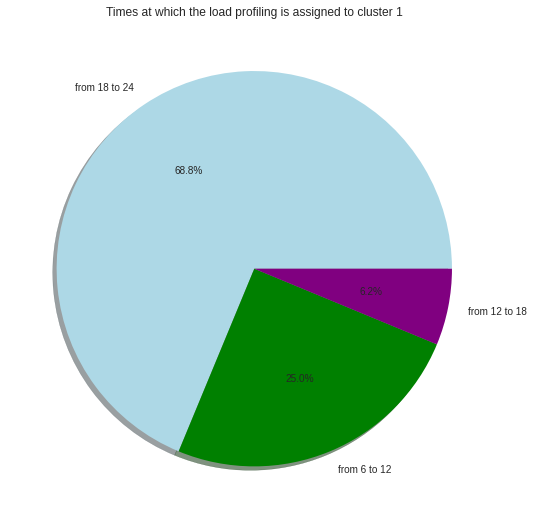

In [ ]:
import matplotlib.ticker as ticker
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt

# plot the pie charts showing relative distribution of daytime for one cluster

plt.figure(1, figsize=(20,20)) 
the_grid = GridSpec(2, 2)


plt.subplot(the_grid[0, 1], aspect=1, title='Times at which the load profiling is assigned to cluster 1')
labels = ['from 18 to 24', 'from 6 to 12', 'from 12 to 18']
type_show_ids = plt.pie(knn_profile_pivot_train2.loc[knn_profile_pivot_train2['cluster']==0, 'number'].value_counts(),
                        labels=labels, autopct='%1.1f%%',
                        shadow=True, colors=['lightblue', 'green', 'purple'])
plt.show()

Figure 2.7: Times of the day identified as cluster 1. 

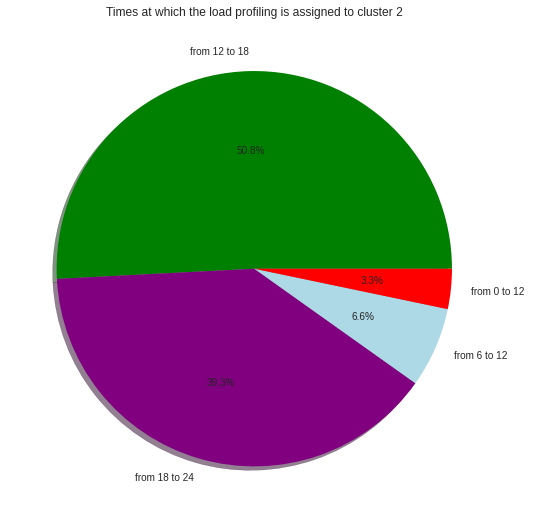

In [ ]:
plt.figure(2, figsize=(20,20)) 
the_grid = GridSpec(2, 2)

plt.subplot(the_grid[0, 1], aspect=1, title='Times at which the load profiling is assigned to cluster 2')
labels = ['from 12 to 18', 'from 18 to 24', 'from 6 to 12', 'from 0 to 12 ']
type_show_ids = plt.pie(knn_profile_pivot_train2.loc[knn_profile_pivot_train2['cluster']==1, 'number'].value_counts(),
                        labels=labels, autopct='%1.1f%%',
                        shadow=True, colors=['green', 'purple', 'lightblue', 'red'])
plt.show()


Figure 2.8: Times of the day identified as cluster 2. 

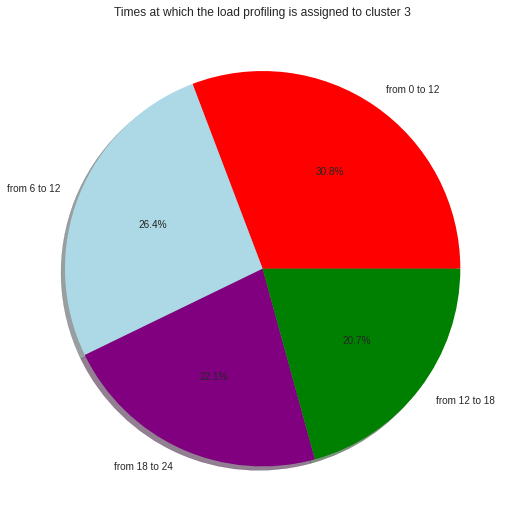

In [ ]:
plt.figure(1, figsize=(20,20)) 
the_grid = GridSpec(2, 2)

plt.subplot(the_grid[0, 1], aspect=1, title='Times at which the load profiling is assigned to cluster 3')
labels = ['from 0 to 12',  'from 6 to 12', 'from 18 to 24', 'from 12 to 18']
type_show_ids = plt.pie(knn_profile_pivot_train2.loc[knn_profile_pivot_train2['cluster']==2, 'number'].value_counts(),
                        labels=labels, autopct='%1.1f%%',
                        shadow=True, colors=['red', 'lightblue', 'purple', 'green'])
plt.show()


Figure 2.9: Times of the day identified as cluster 3. 

From the T-SNE below we can see that our algorithm was able to distinguish and moderately separate the clusters.

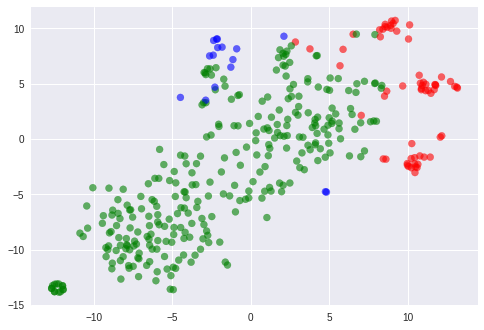

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.colors

# plot the TSNE diagramm 

tsne = TSNE(perplexity=50, n_components=2)
results_tsne = tsne.fit_transform(X)


cmap = matplotlib.colors.LinearSegmentedColormap.from_list(cluster_values, color_list)


results_tsne = tsne.fit_transform(X)
plt.scatter(results_tsne[:,0], results_tsne[:,1],
    #c=knn_profile_pivot_train2.index.get_level_values('6-hour'),
    c=knn_profile_pivot_train2['cluster'],
    cmap=cmap, 
    alpha=0.6,
    );



Figure 2.10: T-SNE projection for 6 hours clusters


Now we append the cluster results to our dataframe to later used it for predictions.

In [ ]:
time_difference_train = full_train['time'].iloc[-1].timetuple().tm_yday - full_train.loc[0, 'time'].timetuple().tm_yday +1 
time_difference_test = full_test['time'].iloc[-1].timetuple().tm_yday - full_test.loc[full_test.index[0], 'time'].timetuple().tm_yday + 1


helping_list = list(range(0, 24))
helping_list = time_difference_train*helping_list



cluster_data_train2 = result_profiles_train2.rename(columns={'date' : 'day'})
cluster_data_train2 = cluster_data_train2.loc[cluster_data_train2.index.repeat(6)]

number_of_rows = len(cluster_data_train2)

helping_list = helping_list[0:number_of_rows]

cluster_data_train2['hour'] = helping_list



full_train['hour'] = full_train['time'].map(lambda x: x.hour)
full_train['day'] = full_train['time'].dt.date
full_train = pd.merge(full_train, cluster_data_train2, on=['day', 'hour'], how='left')
full_train.drop(columns=['day', 'hour'], inplace=True)

In [ ]:
# 0 is Monday
cluster_data_train2['weekday'] = pd.to_datetime(cluster_data_train2['day'], errors='coerce').dt.dayofweek
cluster_data_train2.loc[cluster_data_train2['cluster']==0, ['weekday']].value_counts()
cluster_data_train2.loc[cluster_data_train2['cluster']==1, ['weekday']].value_counts()

weekday
6          102
1           60
0           60
5           54
4           36
2           36
3           18
dtype: int64

In [ ]:
map_color = {}
map_color = {'0':'blue', '1':'red', '2':'green', '3':'orange', '4': 'brown', '5':'black', '6':'pink'}

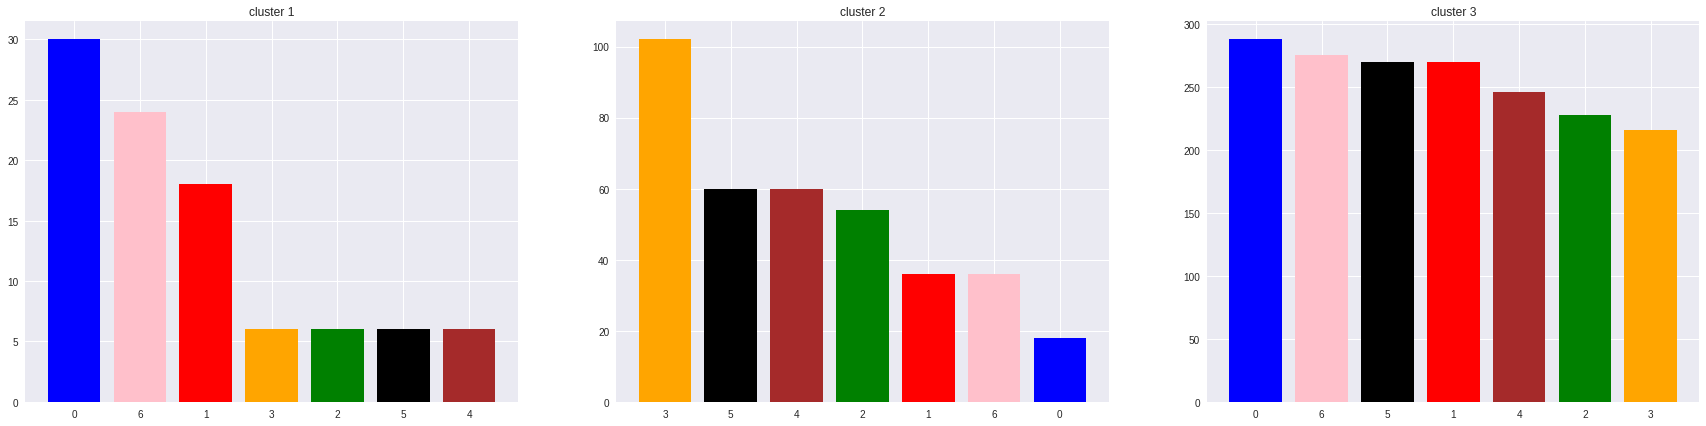

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,7))
#fig.suptitle('Days of the week assigned to each cluster')
ax1.bar(['0', '6', '1', '3', '2', '5', '4'], cluster_data_train2.loc[cluster_data_train2['cluster']==0,
        ['weekday']].value_counts(),
        color=list(map(map_color.get, ['0', '6', '1', '3', '2', '5', '4'])))
ax1.set_title('cluster 1')
ax2.bar(['3', '5', '4', '2', '1', '6', '0'], cluster_data_train2.loc[cluster_data_train2['cluster']==1, 
        ['weekday']].value_counts(),
        color=list(map(map_color.get, ['3', '5', '4', '2', '1', '6', '0'])))
ax2.set_title('cluster 2')
ax3.bar(['0', '6', '5', '1', '4', '2', '3'], cluster_data_train2.loc[cluster_data_train2['cluster']==2, 
        ['weekday']].value_counts(),
        color=list(map(map_color.get, ['0', '6', '5', '1', '4', '2', '3'])))
ax3.set_title('cluster 3');

Figure 2.11: Days of the week assigned to each cluster

In the diagrams above we can see that that some days appear very rarely at some clusters. Nevertheless there is no pattern saying that weekend days belong together very often in the same cluster. 

# 12 Hours

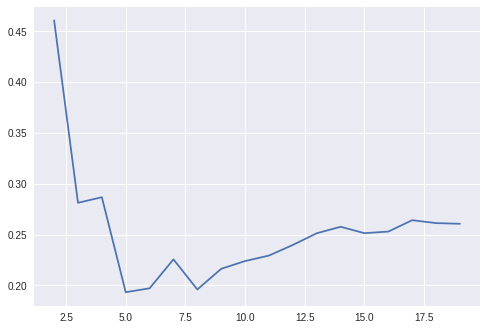

In [ ]:
knn_profile_train3 = knn_profile_train.copy()
knn_profile_train3['12-hour'] = 0
knn_profile_train3.loc[((knn_profile_train3['hour'] >= 8) & (knn_profile_train3['hour']<= 19)), '12-hour' ] = 1
knn_profile_train3.loc[((knn_profile_train3['hour'] >= 20) & (knn_profile_train3['hour']<= 7)), '12-hour' ] = 2

len_frame = len(knn_profile_train3)
if len_frame%12 <=6:
  sequence = np.tile(A = list(range(1, 13)), reps = round(len_frame/12) + 1)
else:
  sequence = np.tile(A = list(range(1, 13)), reps = round(len_frame/12) )

knn_profile_train3['hour'] = sequence[0:(len_frame)]


knn_profile_train3.set_index('12-hour',append=True, inplace=True) 

knn_profile_train3

knn_profile_pivot_train3 = knn_profile_train3.pivot(columns='hour')


knn_profile_pivot_train3 = knn_profile_pivot_train3.dropna()

knn_profile_pivot_train3.columns = knn_profile_pivot_train3.columns.droplevel()


knn_profile_pivot_train3


sillhoute_scores = []
n_cluster_list = np.arange(2,20).astype(int)

X = knn_profile_pivot_train3.values.copy()
# Very important to scale!
X

sc = MinMaxScaler()
X = sc.fit_transform(X)

for n_cluster in n_cluster_list:
    
    kmeans = KMeans(n_clusters=n_cluster, init='k-means++', max_iter=100, n_init=1, 
                               verbose=0,
                               random_state = 42)
    cluster_found = kmeans.fit_predict(X)
    sillhoute_scores.append(silhouette_score(X, kmeans.labels_))

plt.plot(n_cluster_list, sillhoute_scores);




Figure 2.12: Silhouette scores for 12 hours clusters

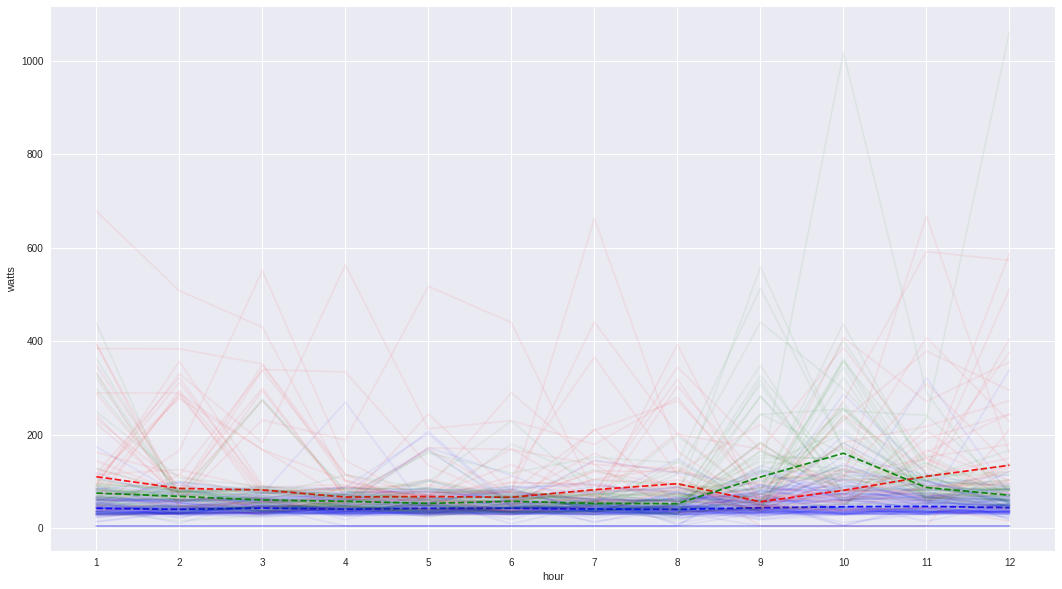

In [ ]:
number = 3
kmeans = KMeans(n_clusters=number, init='k-means++', max_iter=100, n_init=1, 
                               verbose=0,
                               random_state = 42)
cluster_found = kmeans.fit_predict(X)
cluster_found_sr = []
cluster_found_sr = pd.Series(cluster_found, name='cluster')


if isinstance(knn_profile_pivot_train3.index, pd.MultiIndex):
    knn_profile_pivot_train3.index = knn_profile_pivot_train3.index.droplevel(level=1)
    knn_index_train =knn_profile_pivot_train3.index
    knn_profile_pivot_train3 = knn_profile_pivot_train3.set_index(cluster_found_sr, append=True)
else: 
    knn_index_train =knn_profile_pivot_train3.index
    knn_profile_pivot_train = knn_profile_pivot_train3.set_index(cluster_found_sr, append=True)
    
#save the dataframe to a csv data
frame_train = { 'date': knn_index_train, 'cluster': cluster_found_sr.values } 

result_profiles_train3 = pd.DataFrame(frame_train) 

fig, ax= plt.subplots(1,1, figsize=(18,10));
# for the number of clusters choose the colors in case of 2 only blue and red
color_list = ['blue','red','green', 'purple', 'yellow', 'orange', 'brown', 'black', 'pink', 'black'][0:number]

cluster_values = sorted(knn_profile_pivot_train3.index.get_level_values('cluster').unique())

for cluster, color in zip(cluster_values, color_list):
    knn_profile_pivot_train3.xs(cluster, level=1).T.plot(
        ax=ax, legend=False, alpha=0.06, color=color, label= f'Cluster {cluster}'
        );
    knn_profile_pivot_train3.xs(cluster, level=1).median().plot(
        ax=ax, color=color, alpha=0.9, ls='--'
    );

ax.set_xticks(np.arange(1,13));
ax.set_ylabel('watts');
ax.set_xlabel('hour');

Figure 2.13: Energy consumption paths with cluster medians for 12 hours 

Here we can also see that the clusters found are good.

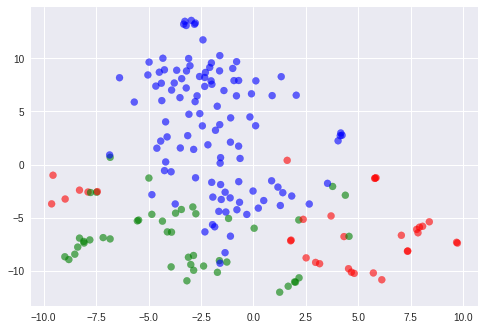

In [ ]:
tsne = TSNE()
results_tsne = tsne.fit_transform(X)

cmap = matplotlib.colors.LinearSegmentedColormap.from_list(cluster_values, color_list)


plt.scatter(results_tsne[:,0], results_tsne[:,1],
    c=knn_profile_pivot_train3.index.get_level_values('cluster'),
    cmap=cmap, 
    alpha=0.6,
    );

Figure 2.14: T-SNE projection for 12 hours clusters

In [ ]:
time_difference_train = full_train['time'].iloc[-1].timetuple().tm_yday - full_train.loc[0, 'time'].timetuple().tm_yday +1 
time_difference_test = full_test['time'].iloc[-1].timetuple().tm_yday - full_test.loc[full_test.index[0], 'time'].timetuple().tm_yday + 1


helping_list = list(range(0, 24))
helping_list = time_difference_train*helping_list



cluster_data_train3 = result_profiles_train3.rename(columns={'date' : 'day'})
cluster_data_train3 = cluster_data_train3.loc[cluster_data_train3.index.repeat(6)]

number_of_rows = len(cluster_data_train3)

helping_list = helping_list[0:number_of_rows]

cluster_data_train3['hour'] = helping_list



full_train['hour'] = full_train['time'].map(lambda x: x.hour)
full_train['day'] = full_train['time'].dt.date
full_train = pd.merge(full_train, cluster_data_train3, on=['day', 'hour'], how='left')
full_train.drop(columns=['day', 'hour'], inplace=True)

# 3.Anomaly Detection

## 3.1 Autoencoders for detecting anomalous days

Naturaly when looking at recurring patterns the question arised regarding the other observations not occuring within regular patterns. Attempting to predict not normal enrgy consumptions seperatly might be defined as detecting anomalies that refer to not normal user behavior as a deviation from usual behaviour. This type of anomaly detection, is also referred to as outlier detection and mainly tries to forecast the occurence of an unusual long usage time period for an appliance or an unusally high aggregate energy demand so called peak loads.

Peak load detection and prediction is commonly used for higher level aggregate energy data in order to better utilize the energy network structure and incentivise individuals to change energy consumption behaviour. Beeing able to detect these peaks previously would also help the prediction methods presented above to be better in predicting spikes. Another common interpretation of anomaly detection more on household level is often to detect unusual energy consumption on appliance level in order to detect defaulting appliances.


There has been several ways of dealing with anomalies in the power consumption data. One of them is introduced in Chahla et al. (2019). The researchers first with the help of autoencoders detect anomalous days. The 24 hours of a daily load profiles are used to recreate this 24 hours. The recreated days that vary considerably from their original counterparts are treated as anomalous and are not included into training of the main model.

In this notebook we will adopt the aforementioned approach and look at anomalies from a perspective that allow us to predict whether an anomaly will occur in the next hour.

To do that we first need to transform the training data into a form that the autoencoders will accept. 






In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler


def generate_datasets_for_training(data, window_size, scale=True, scaler_type=StandardScaler):
  '''Function generates a dataset that if compatibile for our autoencoder daily anomaly prediction model'''

  _l = len(data)

  data = scaler_type().fit_transform(data)
  Xs = []
  Ys = []
  counter = 1
  for i in range(0, (_l - window_size), window_size):
    # because this is an autoencoder - our Ys are the same as our Xs. No need to pull the next sequence of values
    Xs.append(data[i:i+window_size])
    Ys.append(data[i:i+window_size])


  tr_x, tr_y, ts_x, ts_y = [np.array(x) for x in train_test_split( Xs, Ys)]

  Xs = [x.tolist() for x in Xs]
  Ys = [x.tolist() for x in Ys]

  #tr_x, tr_y, ts_x, ts_y = [np.array(x) for x in train_test_split(Xs, Ys)]
  #print(ts_x, len(tr_y))
  assert tr_x.shape[2] == ts_x.shape[2] == (data.shape[1] if (type(data) == np.ndarray) else len(data))
  #return  (tr_x.shape[2], tr_x, tr_y, ts_x, ts_y)
  return  (tr_x.shape[2], Xs, Ys)


In the cell below we make sure that each of our dataset has the 'aggregated_power' column. Later we call the function that prepares our data for the LSTM autoencoders. 

In [ ]:
#anomaly_detection.reset_index(inplace=True)


columns = ['television', 'fan', 'fridge', 'laptop computer',
       'electric heating element', 'oven', 'blender', 'washing machine',
       'microwave', 'toaster', 'sockets', 'cooker']


# aggregate appliances consumption power for each of the datasets 

appliance_power_locs = []

for i in columns: appliance_power_locs.append(full_train.columns.get_loc(i))


full_train['aggregated_power'] = full_train.apply(aggregate_appliances, axis=1, args = (appliance_power_locs))



appliance_power_locs = []

for i in columns: appliance_power_locs.append(full_train.columns.get_loc(i))



full_val['aggregated_power'] = full_val.apply(aggregate_appliances, axis=1, args = (appliance_power_locs))

appliance_power_locs = []

for i in columns: appliance_power_locs.append(full_train.columns.get_loc(i))


full_test['aggregated_power'] = full_test.apply(aggregate_appliances, axis=1, args = (appliance_power_locs))


# execute function on the train dataset 

feats, X, Y = generate_datasets_for_training(full_train['aggregated_power'].values.reshape(-1,1), 24)

appended_data = full_train['aggregated_power'].append(full_val['aggregated_power'])


# crete a data set from train and test set
feats1, X1, Y1 = generate_datasets_for_training(appended_data.values.reshape(-1,1), 24) 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

Below is the structure of our autoencoder. It takes as input a squence of 24 hours and each sequence is a different day. It outputs the 24 hour sequence as well. We use three encoder LSTM layers and three decoder LSTM layers. The first, second and third imput layers have size 48, 24, and 10 respectively and the three decoder layers the other way around. We train the network for 100 epochs with the batch size equal to one.  

In [ ]:
epochs = 100
batch_size = 1
window_length = 24

from keras import metrics
import keras

#import tensorflow as tf
import tensorflow.compat.v1 as tf

import os
import random as rn 
from tensorflow.compat.v1.keras import backend as K


number = 2

os.environ['PYTHONHASHSEED']=str(number)

#Set random seed for numpy, python and tensorflow
np.random.seed(number)
rn.seed(number)
tf.set_random_seed(number)

# Set the number of threads to 1 
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)
##############################




# Conctruct autoencoder for training test to find anomalous days in the data
model = keras.Sequential()
model.add(keras.layers.LSTM(48, kernel_initializer='he_uniform', batch_input_shape=(None, window_length, feats), return_sequences=True, name='encoder_1'))
model.add(keras.layers.Dropout(rate=0.3))

model.add(keras.layers.LSTM(24, kernel_initializer='he_uniform', return_sequences=True, name='encoder_2'))
model.add(keras.layers.Dropout(rate=0.3))

model.add(keras.layers.LSTM(10, kernel_initializer='he_uniform', return_sequences=False, name='encoder_3'))

model.add(keras.layers.RepeatVector(window_length, name='encoder_decoder_bridge'))

model.add(keras.layers.LSTM(10, kernel_initializer='he_uniform', return_sequences=True, name='decoder_1'))
model.add(keras.layers.Dropout(rate=0.3))
model.add(keras.layers.LSTM(24, kernel_initializer='he_uniform', return_sequences=True, name='decoder_2'))
model.add(keras.layers.Dropout(rate=0.3))
model.add(keras.layers.LSTM(48, kernel_initializer='he_uniform', return_sequences=True, name='dncoder_3'))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(feats)))
#opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss="mse",optimizer='adam')
model.build()
print(model.summary())


# run the autoencoder model trained on the train set

history_per = model.fit(x=X, y=Y, epochs=epochs, batch_size=batch_size, shuffle=False #, callbacks=[early_stop]
          )

number = 2

os.environ['PYTHONHASHSEED']=str(number)

#Set random seed for numpy, python and tensorflow
np.random.seed(number)
rn.seed(number)
tf.set_random_seed(number)

# Set the number of threads to 1 
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)
##############################



# run the autoencoder model trained on the test set
history_per1 = model.fit(x=X1, y=Y1, epochs=epochs, batch_size=batch_size, shuffle=False #, callbacks=[early_stop]
          )




Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_1 (LSTM)             (None, 24, 48)            9600      
_________________________________________________________________
dropout (Dropout)            (None, 24, 48)            0         
_________________________________________________________________
encoder_2 (LSTM)             (None, 24, 24)            7008      
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24)            0         
_________________________________________________________________
encoder_3 (LSTM)             (None, 10)                1400      
_________________________________________________________________
encoder_decoder_bridge (Repe (None, 24, 10)            0         
_________________________________________________________________
decoder_1 (LSTM)             (None, 24, 10)            8

We can see in the plot below that our network was able to learn the structure of the data by the constantly decreasing loss. 

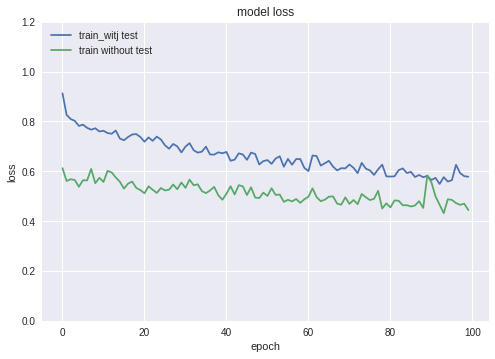

In [ ]:
# summarize history for loss
def plot_history(metric1, metric2, y_min=0, y_max = 2):
  '''
  metric1: training loss
  metric2: validation loss
  '''
  plt.plot(metric1)
  plt.plot(metric2)
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train_witj test', 'train without test'], loc='upper left')
  plt.ylim(y_min, y_max)

  plt.show()

plot_history(history_per.history['loss'], history_per1.history['loss'], 0, 1.2)

Figure 3.1: Learning Curve Autoencoder for anomaly detection.

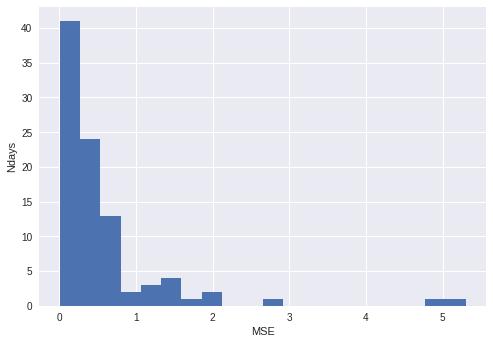

In [ ]:
from sklearn.metrics import mean_squared_error
X_pred1 = model.predict(X1)
X_pred = model.predict(X)

#obtain mean square error for each day between predicted 24 hours and actual 24 hours 

train_mse_loss = np.mean(np.square(X_pred - X), axis=1)
train_mse_loss1 = np.mean(np.square(X_pred1 - X1), axis=1)


#plot the mean square error as histogram

from google.colab import files

plt.hist(train_mse_loss, bins=20);

plt.ylabel('Ndays')
plt.xlabel('MSE')

plt.savefig(DATA_DIR+"histogramm2.png")

#files.download("histogramm2.png") 

anomaly_day_indices = [idx for idx, val in enumerate(train_mse_loss) if val > 2.5]
anomaly_day_indices1 = [idx for idx, val in enumerate(train_mse_loss1) if val > 2.5]



number_of_days1 = np.array(X_pred1).shape[0]

X_reshaped1 = np.array(X1).reshape(number_of_days1,24)

X_pred_reshaped1 = np.array(X_pred1).reshape(number_of_days1,24)

X_reshaped1 = np.concatenate((X_reshaped1, X_pred_reshaped1))



number_of_days = np.array(X_pred).shape[0]


X_reshaped = np.array(X).reshape(number_of_days,24)
X_pred_reshaped = np.array(X_pred).reshape(number_of_days,24)


X_reshaped = np.concatenate((X_reshaped, X_pred_reshaped))



Figure 4.2: Histogram of MSEs for each predicted day. 

We compare the predicted 24 hour sequences to the actual 24 hour sequences with marginal squared error. The above graphic shows for how many days a specific standard error occured. The predicted days that daviate the most from the original data are classified as anomalies. In this case we set our threshold to four and this yields us two anomalous days. 

After that just for visualization purposes we plot a TSNE diagramm below with original and predicted data to see how does the 24 hour sequence look in the two dimensional space. 

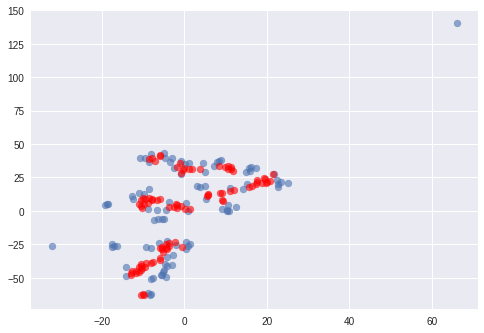

In [ ]:
# plot TSNE of diagramm for orginal data (blue) and predicted data (red)
from sklearn.manifold import TSNE
np.random.seed(42)
X_embedded = TSNE(n_components=2, perplexity=8, early_exaggeration=12, learning_rate=200).fit_transform(X_reshaped)
plt.scatter(X_embedded[:number_of_days,0], X_embedded[:number_of_days,1],
     
    alpha=0.6,
    );

plt.scatter(X_embedded[number_of_days:,0], X_embedded[number_of_days:,1],
    color='red',      
    
    alpha=0.6,
    );

Figure 4.3: TSNE for original and predicted days. 

In [ ]:
# from full_train delete the indices where the days are anomalous 

def get_anomulous_rows(anomaly_indices):
  '''delete all rows for which days are anomalous'''
  
  anoma = []

  for n in anomaly_day_indices:
      anoma.extend([*range(n*24, (n*24)+24)])

  return anoma


full_train_without_anomalies = full_train.drop(get_anomulous_rows(anomaly_day_indices))
full_train_without_anomalies1 = full_train.drop(get_anomulous_rows(anomaly_day_indices1))


## 3.2. Hourly anomaly prediction with LSTMs and Kmeans clustering

The second step of the anomaly prediction process is to predict next hour based on 24 hours before with the use of training data for which the days are not classified as anomalous. To do that we apply a three layer LSTM modell of size 48 each. After each layer there is a dropout layer set to 0.2. The last layer is a dense layer of size one to predict the next our. The model is traied with 40 epochs.



In [ ]:
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Input
from keras.layers import concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.utils import plot_model
from keras import optimizers


# build a model that predicts the next hour based on 24 hours before






def build_anomaly_model(train_x, train_y, val_x, val_y, n_input, n_out, n_epochs#, train, validation,
                ):
  '''
  train: training data for model
  validation: validation data for model
  n_input: window length of input sequence
  n_out: size of timesteps to be predicted per input
  '''


  number = 2

  os.environ['PYTHONHASHSEED']=str(number)

  #Set random seed for numpy, python and tensorflow
  np.random.seed(number)
  rn.seed(number)
  tf.set_random_seed(number)

  # Set the number of threads to 1 
  session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
  sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
  K.set_session(sess)
  ##############################

  verbose, epochs, batch_size = 1, n_epochs, 1 #6732
  n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape output into [samples, timesteps, features]
  train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
  
  #visible = Input(shape= (n_timesteps, n_features))
  visible = Input(batch_shape= (batch_size, n_timesteps, n_features))
  #encoder = LSTM(200, activation='relu')(visible)
  encoder = LSTM(48, return_sequences=True)(visible) #, stateful=True
  encoder = Dropout(0.2)(encoder)
  visible2 = LSTM(48, return_sequences=True)(encoder)
  encoder2 = Dropout(0.2)(visible2)
  visible3 = LSTM(48, return_sequences=False)(encoder2)
  encoder3 = Dropout(0.2)(visible3)
  



  decoder = Dense(1)(encoder3)
  model = Model(inputs=visible, outputs=decoder)

  optimizer = optimizers.Adam(lr=0.001)
  model.compile(loss='mse', optimizer=optimizer)
	# fit network

  history_per = model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle=False)
  

  return model, history_per

# evaluate a single model
def evaluate_anomaly_model(train_x, train_y, val_x, val_y, n_input, n_out, n_epochs):
  '''
  train: training data for model
  validation: validation data for model
  test: test data to make predictions on
  n_input: window length of input sequence
  n_out: size of timesteps to be predicted per input
  '''
	# fit model
  model, history_per = build_anomaly_model(train_x, train_y, val_x, val_y, n_input, n_out, n_epochs)

  print('finished build model')
  yhat = model.predict(train_x, batch_size=1, verbose=0)
  #print('fnished predict')
  #return yhat, history_per, model
  return yhat, history_per, model



With the function 'generate_datasets_for_training_LSTM' we bring all of our datasets to a format that fits our task and is appropriante to be injected a input to our LSTM. 

In [ ]:
def generate_datasets_for_training_LSTM(data, valid_data, test_data, window_size, scale=True, scaler_type=StandardScaler):
  _l = len(data)
  _l_valid = len(valid_data)

  _l_test = len(test_data)

  scalery = scaler_type().fit(data)

  data = scalery.transform(data) 

  valid_data = scalery.transform(valid_data) 

  test_data = scalery.transform(test_data)
  
  Xs = []
  Ys = []
  counter = 1
  for i in range(0, (_l - window_size)):
    # because this is an autoencoder - our Ys are the same as our Xs. No need to pull the next sequence of values
    Xs.append(data[i:i+window_size])

  for j in range(window_size, _l):
    Ys.append(data[j])

  tr_x = np.array(Xs)
  tr_y = np.array(Ys)

  Xs = []
  Ys = []
  counter = 1
  for i in range(0, (_l_valid - window_size)):
    # because this is an autoencoder - our Ys are the same as our Xs. No need to pull the next sequence of values
    Xs.append(valid_data[i:i+window_size])

  for j in range(window_size, _l_valid):
    Ys.append(valid_data[j])

  val_x = np.array(Xs)
  val_y = np.array(Ys)


  Xs = []
  Ys = []
  counter = 1
  for i in range(0, (_l_test - window_size)):
    # because this is an autoencoder - our Ys are the same as our Xs. No need to pull the next sequence of values
    Xs.append(test_data[i:i+window_size])

  for j in range(window_size, _l_test):
    Ys.append(test_data[j])

  test_x = np.array(Xs)
  test_y = np.array(Ys)

  #if we want the split than

  #tr_x, tr_y, ts_x, ts_y = [np.array(x) for x in train_test_split( Xs, Ys)]
  #tr_x, tr_y, ts_x, ts_y = [np.array(x) for x in train_test_split(Xs, Ys)]
  #print(ts_x, len(tr_y))
  #assert tr_x.shape[2] == ts_x.shape[2] == (data.shape[1] if (type(data) == np.ndarray) else len(data))
  #return  (tr_x.shape[2], tr_x, tr_y, ts_x, ts_y, scalery)
  return  (tr_x.shape[2], tr_x, tr_y, val_x, val_y, test_x, test_y, scalery)
  
feats, X, Y, X_valid, Y_valid, X_test, Y_test, scaler = generate_datasets_for_training_LSTM(full_train_without_anomalies['aggregated_power'].values.reshape(-1,1),
                                                                            full_val['aggregated_power'].values.reshape(-1,1),
                                                                            full_test['aggregated_power'].values.reshape(-1,1), window_size = 24)



In [ ]:
feats1, X1, Y1, X_valid, Y_valid, X_test, Y_test, scaler = generate_datasets_for_training_LSTM(full_train_without_anomalies['aggregated_power'].values.reshape(-1,1),
                                                                            full_val['aggregated_power'].values.reshape(-1,1),
                                                                            full_test['aggregated_power'].values.reshape(-1,1), window_size = 24)


In [ ]:

n_input = 24 #6 #72 #36 #6
n_out=1
#test_x, test_y = to_supervised(test, n_input, n_out=n_out)
#print(test_x.shape, test_y.shape)
predictions, history_per, model = evaluate_anomaly_model(train_x = X, train_y = Y, val_x = X_valid, val_y = Y_valid, n_input=n_input, n_out=n_out, n_epochs = 10) #
#predictions, model = evaluate_model(train, validation, test_x, n_input, n_out=n_out, n_epochs = 2) 


Epoch 1/10
2160/2160 [==============================] - 35s 14ms/step - loss: 1.1706 - val_loss: 0.4596
Epoch 2/10
2160/2160 [==============================] - 30s 14ms/step - loss: 1.0534 - val_loss: 0.3679
Epoch 3/10
2160/2160 [==============================] - 30s 14ms/step - loss: 1.0134 - val_loss: 0.3863
Epoch 4/10
2160/2160 [==============================] - 30s 14ms/step - loss: 0.9947 - val_loss: 0.3755
Epoch 5/10
2160/2160 [==============================] - 30s 14ms/step - loss: 0.9878 - val_loss: 0.3862
Epoch 6/10
2160/2160 [==============================] - 30s 14ms/step - loss: 0.9852 - val_loss: 0.3824
Epoch 7/10
2160/2160 [==============================] - 30s 14ms/step - loss: 0.9592 - val_loss: 0.3723
Epoch 8/10
2160/2160 [==============================] - 30s 14ms/step - loss: 0.9665 - val_loss: 0.3775
Epoch 9/10
2160/2160 [==============================] - 30s 14ms/step - loss: 0.9490 - val_loss: 0.3741
Epoch 10/10
2160/2160 [==============================] - 30s 14m

In [ ]:
predictions1, history_per1, model1 = evaluate_anomaly_model(train_x = X1, train_y = Y1, val_x = X_valid, val_y = Y_valid, n_input=n_input, n_out=n_out, n_epochs = 10)


Epoch 1/10
2160/2160 [==============================] - 35s 14ms/step - loss: 1.1706 - val_loss: 0.4596
Epoch 2/10
2160/2160 [==============================] - 30s 14ms/step - loss: 1.0534 - val_loss: 0.3679
Epoch 3/10
2160/2160 [==============================] - 30s 14ms/step - loss: 1.0134 - val_loss: 0.3863
Epoch 4/10
2160/2160 [==============================] - 30s 14ms/step - loss: 0.9947 - val_loss: 0.3755
Epoch 5/10
2160/2160 [==============================] - 29s 14ms/step - loss: 0.9878 - val_loss: 0.3862
Epoch 6/10
2160/2160 [==============================] - 30s 14ms/step - loss: 0.9852 - val_loss: 0.3824
Epoch 7/10
2160/2160 [==============================] - 30s 14ms/step - loss: 0.9592 - val_loss: 0.3723
Epoch 8/10
2160/2160 [==============================] - 30s 14ms/step - loss: 0.9665 - val_loss: 0.3775
Epoch 9/10
2160/2160 [==============================] - 30s 14ms/step - loss: 0.9490 - val_loss: 0.3741
Epoch 10/10
2160/2160 [==============================] - 30s 14m

In [ ]:
original_predictions = model.predict(X_test, batch_size=1)

predicted_predictions = model1.predict(X_test, batch_size=1)


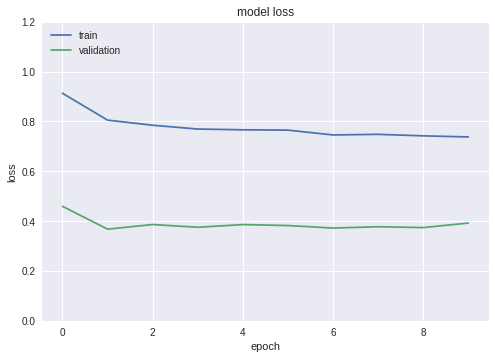

In [ ]:
# summarize history for loss
def plot_history(metric1, metric2, y_min=0, y_max = 2):
  '''
  metric1: training loss
  metric2: validation loss
  '''
  plt.plot(metric1)
  plt.plot(metric2)
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.ylim(y_min, y_max)

  plt.show()


plot_history(history_per.history['loss'], history_per.history['val_loss'] , 0, 1.2)

Figure 3.4: Learning curve for LSTM predicting a next hour based on 24 hours before.

As visible in the figure above the model can learn well but it cannot generalise well on the validation set. 

The cell below contains code that is crucial to our approach. For each hour of the day it clusters the data into similar groups. So in the end we peform clustering algorithm 24 times (each time for 1 hour of the day). For each hour the KMeans algorithm finds six clusters and the function clusterings returns the centers of this clusters. 

In [ ]:
#Split the data into data with the same hours and store all the arrays in one array
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score

data_for_clusters = full_train_without_anomalies['aggregated_power'].values.reshape(-1,1)

clusters = [data_for_clusters[range(j, len(data_for_clusters), 24)] for j in range(0, 24)]

def clusterings(data):
    cluster_centers = []
    for hour in range(0,24):
    
        kmeans = KMeans(n_clusters=6, init='k-means++', max_iter=100, n_init=1, 
                                verbose=0,
                                random_state = 42)
             
        cluster_found = kmeans.fit_predict(data[hour])

        cluster_centers.append(kmeans.cluster_centers_)

    return cluster_centers

              
cluster_centers = clusterings(clusters)

Next we calculate the distance between each predicted hour and the closest centroid from the KMeans clustering for each hour of the day. 

In [ ]:

# the problem is we dont know which observations belong to each 24 profile - we have to delete the whole Train Test split

def calculate_closest_distance(predictions, cluster_centers):


  distances = []

  
  for i in range(0, window_length):
    _listy = []
    for j in range(i, len(predictions),  window_length):
      

        _listy.append(min(np.abs(cluster_centers[1] - predictions[j])))


    distances.append(_listy)

  return distances

The function below yield indices for each of the data sets for which the distance is higher that our set threshold. We set the threshold equal to 50. 

In [ ]:
def get_indices_with_anomalies(data, cluster_centers, anomaly_threshold = 13, predictions_available = False, scaler = scaler):

  if not predictions_available:
      
      data = model.predict(data, batch_size=1)  

  data = scaler.inverse_transform(data)
  
  distances_to_centroids = calculate_closest_distance(data, cluster_centers)
   
  distances_to_centroids_reversed = []

  for i in range(len(distances_to_centroids[23])): distances_to_centroids_reversed.append([item[i] for item in distances_to_centroids])

  distances_to_centroids_reversed = [item for sublist in distances_to_centroids_reversed for item in sublist]

  
  #anomaly_predictions = list(map(lambda x: x>=anomaly_threshold, distances_to_centroids_reversed))

  anomaly_indices = [i for i, x in enumerate(distances_to_centroids_reversed) if x >= anomaly_threshold]

  return anomaly_indices, distances_to_centroids_reversed



# obtain the row indices in which the anomalies are occuring for each dataset  by calling the get_indices_with_anomalies function

training_anomaly_indices, d_training = get_indices_with_anomalies(data = predictions, cluster_centers = cluster_centers, anomaly_threshold = 13, predictions_available = True)

test_anomaly_indices, d_test =  get_indices_with_anomalies(data = X_test, cluster_centers = cluster_centers, anomaly_threshold = 13, predictions_available = False)

vali_anomaly_indices, d_vali =  get_indices_with_anomalies(data = X_valid, cluster_centers = cluster_centers, anomaly_threshold = 13)

In [ ]:
from collections import Counter

print(f'Mean of list: {sum(d_training)/len(d_training)}')
print(f'Median of list: {d_training[int(len(d_training)/2)]}')


Mean of list: [8.44807147]
Median of list: [0.26696069]


{'boxes': [<matplotlib.lines.Line2D at 0x7f6e150063d0>],
 'caps': [<matplotlib.lines.Line2D at 0x7f6e150104d0>,
 'fliers': [],
 'means': [<matplotlib.lines.Line2D at 0x7f6e15014510>],
 'medians': [<matplotlib.lines.Line2D at 0x7f6e15010f90>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f6e15006a10>,
  <matplotlib.lines.Line2D at 0x7f6e15006f50>]}

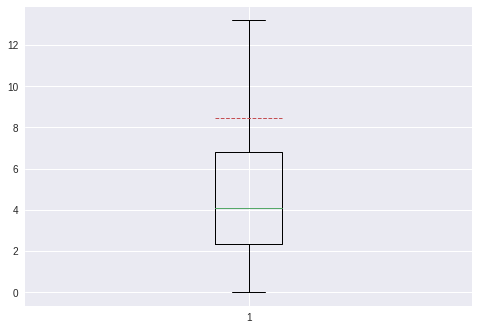

In [ ]:
lst_ar = np.array(d_training)

plt.boxplot(lst_ar, meanline=True, showmeans=True, showfliers=False)


In [ ]:
lst_ar

In [ ]:
test = pd.Series(np.around(lst_ar))
test.value_counts()

4.0      332
3.0      295
1.0      262
5.0      245
2.0      206
        ... 
129.0      1
72.0       1
96.0       1
54.0       1
80.0       1
Length: 97, dtype: int64

In [ ]:
print(test.value_counts()[test.value_counts()>=5])



4.0     332
3.0     295
1.0     262
5.0     245
2.0     206
7.0     138
6.0     130
0.0     108
8.0      95
9.0      56
10.0     44
23.0     13
18.0      9
13.0      8
14.0      8
12.0      7
19.0      7
27.0      7
38.0      6
44.0      6
16.0      6
17.0      6
37.0      6
33.0      5
31.0      5
22.0      5
20.0      5
24.0      5
25.0      5
59.0      5
dtype: int64


In [ ]:
'''
10 = 44
9 = 56
'''

In [ ]:
test2_anomaly_indices = get_indices_with_anomalies(data = X_test, cluster_centers = cluster_centers, anomaly_threshold = 13, predictions_available = False)

In [ ]:
model_for_anomaly_detection = model

In [ ]:
from sklearn.metrics import mean_absolute_error
a = np.zeros((1,312))
b = np.zeros((1,312))

for i in test_anomaly_indices:
    a[0][i] = 1
for i in test2_anomaly_indices:
    b[0][i] = 1

In [ ]:
# check how often and where the anomalies are present 
b[0]


array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1.

In [ ]:
#check where and hor often the anomalies are present in the second model
a[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1.

In [ ]:
from sklearn.metrics import accuracy_score 

accuracy_score(b[0], a[0])

1.0

In [ ]:
training_anomaly_indices = [x+24 for x in training_anomaly_indices]
vali_anomaly_indices = [x+24 for x in vali_anomaly_indices]
test_anomaly_indices = [x+24 for x in test_anomaly_indices]

# 4. LSTM Network with Encoder-Decoder Structure

Generally RNN and LSTM models have proven to be quite good in forecasting time series data and finding sequence patterns. They are capable of learning some temporal ordering of input sequences and they use an internal memory to remember information across long input sequences. This means they automatically learn features from sequence data and can handle variable length input and output sequences that can be used for multi-step forecasting.

The LSTM network works with memory blocks that contain memory cells to maintain information over a long period of time. Updates of the memory is managed through three different gates. The forget gate decides on relevant information to keep from prior steps. The input state decides on relevant information needed to add from the current step and the output gate determines what the next hidden state should be.

We will use a simplyfied version of the Sequence-to-Sequence LSTM model (S2S-LSTM). S2S-LSTM models consits of an encoder part and a decoder part. The encoder learns a representation of the  input sequence. In traditional S2S-Models then the weights from the encoder are transferred to the decoder part. The decoder LSTM layer is initialized with the trained encoder weights. Some pre known features of the output sequence such as Hour or Weekday are fed into the decoder layer, which then predicts the output sequence. When predicting output sequences of arbitrary length, an inference model that updates its weights and inputs time step by time step is need. For inference the encoder first trains and outputs the past and then the decoder is used to predict the next outputs updating its weights without seeing new true data.

in our variation we only construct the encoder and decoder layer and transfer the output from the encoder layer directly to the decoder for prediction. (Outputs not! the weights). Through this the decoder becomes a prediction layer. Transfering only the weights yielded worse results so it is not used to obtain prediction results but the architecture can be found at the end of the notebook for interested readers.

 


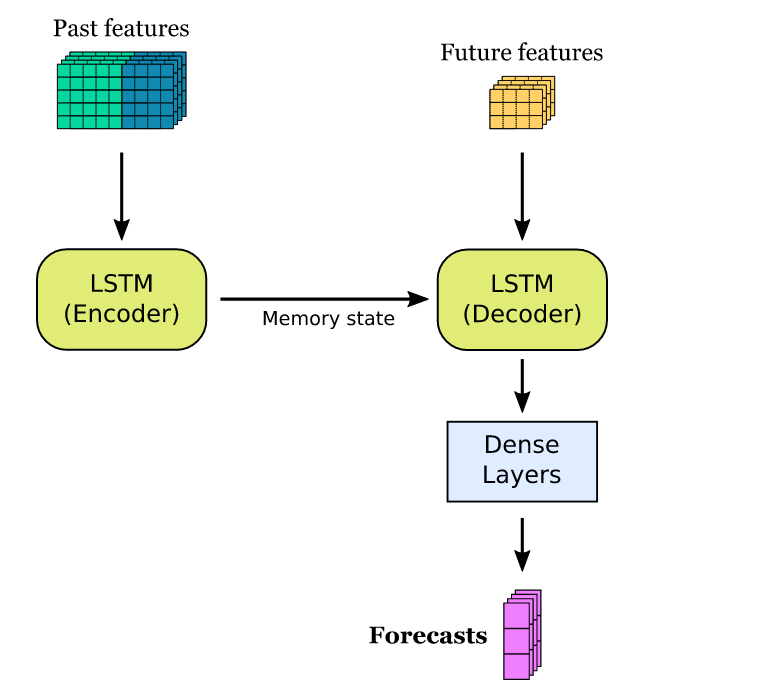

(Angioi, 2021)

Figure: 4.1. LSTM Encoder Decoder Model for Time Series Prediction

### 4.1. Data preparation for model input

In [ ]:
from numpy import split,array
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import tensorflow.compat.v1 as tf


def get_aggregated_data(data):
  '''
  Function stores sum of all apliance level energy 
  usage into a new column called agg_el_mean.

  data: dataset to retreive target variable from
  '''
  data = data.groupby(pd.Grouper( freq='60min', level = None)).mean()
  data.iloc[:,0:12] = data.iloc[:,0:12].replace(0, np.nan)
  data["agg_el_mean"] = data.iloc[:,0:12].sum(axis=1,skipna=True)
  data = data.fillna(0)
  return data



def standardize(data, col, train_scaler=None):
  '''
  The function standardizes columns with a given scaler. 
  If no scaler is defined it creates a new one.

  data:         dataset with unscaled columns
  col:          list of columnames to be standardized
  train_scaler: scaler to use for standardization
  '''

  values = data[col].values
  values = values.reshape((len(values), 1))
  
  if train_scaler==None:
    scaler = MinMaxScaler(feature_range = (-1, 1)).fit(values)
    #scaler = StandardScaler().fit(values)
    standardized = scaler.transform(values)
    return standardized, scaler
  else:
    standardized = train_scaler.transform(values)
    return standardized

def get_windows(train, n_input=6, n_out=1, shift=0):
  '''
  Divides a given dataset into sliding window input and output.
  Output is an array corresponding to X data of shape 
  len(train), n_inputs, n_features; an array corresponding to 
  y data of shape len(train), n_out, 1 and an array corresponding 
  to input features to a decoder model. (not used for paper reults)
  (containes the additional features of the output step such as hour,
  weekday etc. When no additional features available it constructs
  an array of zeros)

  train:   input dataset
  n_input: length of input time steps (window)
  n_out:   length of time steps to be predicted
  shift:   gap size that should be left between input steps and 
           the first step to be predicted
  
  '''
  data = array(train)
  X, y, d_f = list(), list(), list()
  in_start = 0

  for _ in range(len(data)):
    in_end = in_start + n_input
    out_end = in_end + shift + n_out

    if ((out_end <= len(data)) and (data.shape[1]==1)):
      x_input = data[in_start:in_end, 0]
      x_input = x_input.reshape((len(x_input), 1))
      X.append(x_input)
      y.append(data[(in_end + shift):out_end, 0])
      d_f.append(0)
    elif ((out_end <= len(data)) and (data.shape[1]>1)):
      X.append(data[in_start:in_end, :])
      y.append(data[(in_end + shift):out_end, 0])
      d_f.append(data[(in_end + shift):out_end, 1:])

    in_start += 1
  return array(X), array(y), array(d_f)

To feed the results of the anomaly detection algorithm into our model we add a column containing 0 if no anomaly was detected and 1 if an anomaly was detected.
Our anomaly detection algorithm predcits the values for our test data, such that this feature is 'known' in advance for all data points. 

In [ ]:
full_train['anomaly'] = 0
full_train['anomaly'].iloc[training_anomaly_indices] = 1 

full_val['anomaly'] = 0
full_val['anomaly'].iloc[vali_anomaly_indices] = 1 

full_test['anomaly'] = 0
full_test['anomaly'].iloc[test_anomaly_indices] = 1 


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

In [ ]:
#data = apl_data.set_index(keys='time')

data = pd.concat([full_train.set_index(keys='time'),
                  full_val.set_index(keys='time'), 
                  full_test.set_index(keys='time')])

data.head(1)

,television,fan,fridge,laptop computer,electric heating element,oven,blender,washing machine,microwave,toaster,sockets,cooker,appl_pat,cluster_x,cluster_y,cluster,aggregated_power,anomaly
time,,,,,,,,,,,,,,,,,,
2015-08-01,0.0,0.0,27.3566,35.770915,3.715122,0.0,0.0,0.68,1.24,0.0,1.21589,0.0,"fridge, laptop computer, electric heating elem...",0.0,2.0,2.0,69.978528,0


The results from the pattern recognition part are added as One-Hot-Encoded columns, one for each possible 6-hour-cluster. The Colum is 0 if the hour is not associated with the cluster and 1 if it is sorted into the cluster. Hours in the future, i.e. hours in the test set, are sorted into clusters based on our clustering algorithm trained on the training data.

In [ ]:
# first we create data for a simple lstm without any further features:
data_agg = get_aggregated_data(data)

# add cluster data as one hot encoded columns
clusters = np.concatenate((cl_train, cl_test))
data_agg['clusters'] = clusters
y = pd.get_dummies(data_agg.clusters, prefix='clusters')
data_agg = pd.concat([data_agg, y], axis=1)

# add weekday information as one hot encoded columns
data_agg['weekday'] = data_agg.index.weekday
y = pd.get_dummies(data_agg.weekday, prefix='weekday')
data_agg = pd.concat([data_agg, y], axis=1)

# add weekday information as one hot encoded columns
data_agg['hour'] = data_agg.index.hour
y = pd.get_dummies(data_agg.hour, prefix='hour')
data_agg = pd.concat([data_agg, y], axis=1)

# Adding information on active appiances per hour
data_agg[data_agg[['television', 'fan', 'fridge', 'laptop computer',
       'electric heating element', 'oven', 'blender', 'washing machine',
       'microwave', 'toaster', 'sockets', 'cooker']] > 0] = 1
data_agg.columns

Index(['television', 'fan', 'fridge', 'laptop computer',
       'electric heating element', 'oven', 'blender', 'washing machine',
       'microwave', 'toaster', 'sockets', 'cooker', 'cluster_x', 'cluster_y',
       'cluster', 'aggregated_power', 'anomaly', 'agg_el_mean', 'clusters',
       'clusters_0', 'clusters_1', 'clusters_2', 'weekday', 'weekday_0',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'hour', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4',
       'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11',
       'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17',
       'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23'],
      dtype='object')

To run our experiment we subsequently select only the columns of interest from our complete dataset. For a new selection of variables you would need to rerun all the following cells, such that the training process is updated with your new variable selection. 

In [ ]:
# Data selection
dataset = data_agg[[  'agg_el_mean', 'anomaly']].copy() #  
print(dataset.head(2))

                     agg_el_mean  anomaly
time                                     
2015-08-01 00:00:00    69.978528        0
2015-08-01 01:00:00    43.137039        0


In [ ]:
trainset, validationset, testset = split_dataset(dataset,672)

(2256, 2) (336, 2) (336, 2)


In [ ]:
trainset['agg_el_mean'], scaler_train = standardize(trainset, 'agg_el_mean', train_scaler=None)
validationset['agg_el_mean'] = standardize(validationset, 'agg_el_mean', train_scaler=scaler_train)
testset['agg_el_mean'] = standardize(testset, 'agg_el_mean', train_scaler=scaler_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
''' Our chosen input is a time window of 6 hours
to predict the aggregated load of the next hour 
'''
window_len = 6
out_len = 1

''' _decf variables are not used in the first 
prediction, but may be used for the second
encoder decoder model 'with weight transfer'
'''

train_x, train_y, train_decf = get_windows(trainset, window_len, out_len)
val_x, val_y, val_decf = get_windows(validationset, window_len, out_len)
test_x, test_y, test_decf = get_windows(testset, window_len, out_len)
print('test_input', test_x.shape, test_y.shape, test_decf.shape)

n_features = train_x.shape[2]
print(n_features, window_len, out_len)

test_input (330, 6, 2) (330, 1) (330, 1, 1)
2 6 1


### 4.2. LSTM model with encoder decoder type structure

We use three layers to construct the encoder part and four layers to construct the decoder part of our model. The encoder consists of an input layer, an LSTM layer and a dropout layer. The decoder part uses a RepeatVector layer to repeat the output of the encoder as many times as we have output steps. This enables the model to predict a variable length of output. The second decoder layer is an LSTM layer with dimension 72, the third layer is a dropout layer and the last layer is a TimeDistributed layer wrapped around a dense layer of dimension 1. This allows the model to apply the Dense layer to every temporal slice in our model every output timestep. The Timedistributed layer allows to predict the output for each sequence element initiated by the RepeatVector layer.

In [ ]:
##############################


from keras import optimizers
from keras.models import Sequential, Model        
from keras.utils import plot_model
from keras.layers import Dense, Dropout, LSTM, RepeatVector, TimeDistributed, Input

from sklearn.metrics import mean_squared_error

os.environ['PYTHONHASHSEED']=str(138)

#Set random seed for numpy, python and tensorflow
np.random.seed(138)
rn.seed(138)
tf.set_random_seed(138)

from tensorflow.compat.v1.keras import backend as K

# Set the number of threads to 1 
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)
##############################

# model paramters
enc_dim=144
dec_dim=72
lr = 0.0001
optimizer = optimizers.Adam(lr=lr)
loss='mse'
#loss = tf.keras.losses.Huber()
#loss = 'mae'
n_epochs = 10
batch_size = 1

# Encoder
visible = Input(shape= (window_len, n_features))
encoder = LSTM(enc_dim, activation='tanh')(visible) 
encoder = Dropout(0.5)(encoder)

# Decoder
decoder = RepeatVector(out_len)(encoder)
decoder = LSTM(dec_dim, activation='tanh', return_sequences=True)(decoder)
decoder = Dropout(0.5)(decoder)
decoder = TimeDistributed(Dense(1))(decoder)
model = Model(inputs=visible, outputs=decoder)

model.compile(loss=loss, 
              optimizer=optimizer, 
              metrics=['mean_absolute_percentage_error'])

# Train model
history = model.fit(train_x, train_y, validation_data=(val_x, val_y), 
                    epochs=n_epochs, batch_size=batch_size, shuffle=False)

Epoch 1/10
2250/2250 [==============================] - 17s 6ms/step - loss: 0.1776 - mean_absolute_percentage_error: 45.1058 - val_loss: 0.0128 - val_mean_absolute_percentage_error: 20.0483
Epoch 2/10
2250/2250 [==============================] - 13s 6ms/step - loss: 0.0442 - mean_absolute_percentage_error: 27.8157 - val_loss: 0.0100 - val_mean_absolute_percentage_error: 17.6804
Epoch 3/10
2250/2250 [==============================] - 13s 6ms/step - loss: 0.0402 - mean_absolute_percentage_error: 26.3460 - val_loss: 0.0121 - val_mean_absolute_percentage_error: 20.1248
Epoch 4/10
2250/2250 [==============================] - 13s 6ms/step - loss: 0.0402 - mean_absolute_percentage_error: 27.0061 - val_loss: 0.0099 - val_mean_absolute_percentage_error: 18.0078
Epoch 5/10
2250/2250 [==============================] - 13s 6ms/step - loss: 0.0376 - mean_absolute_percentage_error: 26.1801 - val_loss: 0.0105 - val_mean_absolute_percentage_error: 18.5967
Epoch 6/10
2250/2250 [=======================

In [ ]:
yhat = model.predict(test_x,  verbose=0)

In [ ]:
def plot_test_values(yhat, data, target, xaxis):
  '''
  yhat: predictions made
  data: original dataframe with true target values
  target: column name of target value
  xaxis: Name of x-axis in plot
  '''
  fc = data.tail(len(yhat)).copy()
  fc.reset_index(inplace=True)
  fc['forecast'] = yhat
  # Ploting the forecasts
  plt.figure(figsize=(12, 8))
  for dtype in [target, 'forecast']:
    plt.plot(xaxis, dtype, data=fc,
             label=dtype, alpha=0.8)
  plt.legend()
  plt.grid()
  plt.show()

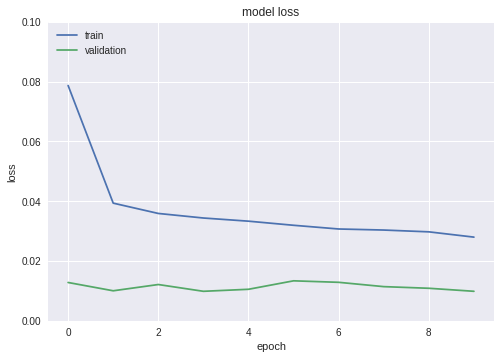

In [ ]:
# Evaluate
plot_history(history.history['loss'], history.history['val_loss'], 0, 0.1) #0.06

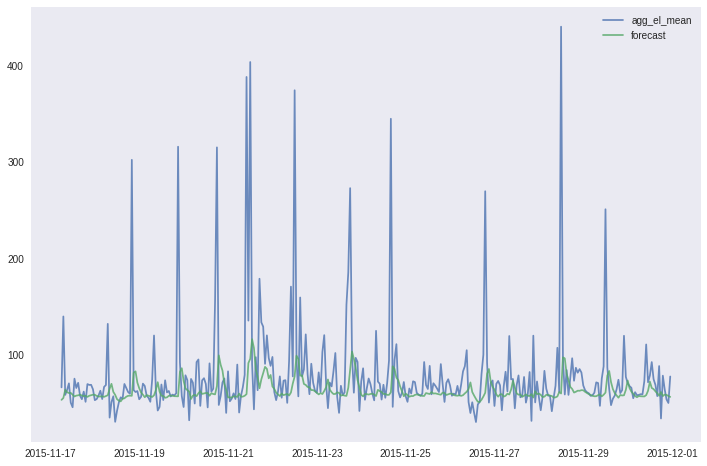

In [ ]:
# Output window = 1
predictions = scaler_train.inverse_transform(yhat[:, :, 0])

# Output window > 1
#yhat = yhat[0::6].flatten() 
#yhat = yhat.reshape(yhat.shape[0],1)
#print(yhat.shape)
#predictions = scaler_train.inverse_transform(yhat)

predictions = predictions.flatten()

plot_test_values(predictions, data_agg, 'agg_el_mean', 'time')

### 4.3. Evaluation and Comparison Metrics 
Load data is quite difficult to predict at is often contains few large spikes in load consumption. The root mean squared error (RMSE) punishes larger errors more, becasue larger errors increase the reported error more. We use the RMSE across all test predictions to evaluate how the model is able to predict the volatility of the data, i.e. how capable they are in predicting larger load spikes. 

The Mean Absolute Error (MAE) puts the same weight on each error. We report the MAE together the the Bias in order to compare whether the used loss function 'mse' is a good fit. If the bias is low it is an indication that the mse we use is a good loss metric. We expect the mse loss metric to be a better fit for our model as it puts more weights on larger errors and we want the spikes to be predicted well. (results using the mae as loss function report large biases so we know the mse is a better fit.)

Last Error Metric we report is the Mean Absolute Percentage Error (MAPE). This mteric is independent of the underlying data values as it is reported in percentages. We can use this metric to compare our results to state of the art results.

As reference value we use the RMSE and MAPE from a naive forecasting model (persistence model) that sets the previous time step as forecasting value for the next timestep. The persistence forecast on the test set will be our comparison value and the lower acceptable bound of performance. 

We additionally report the number of predictions with a larger value than 100 and the largest value predicted to see how good the model captures larger spikes.


In [ ]:
def values_over_hund(data):
  #array(data)
  occurr = data > 100
  total = occurr.sum()
  return totaldef calc_rmse(predictions, target_data, target_col):
  targets = target_data[target_col][-len(predictions):].to_numpy()
  return np.sqrt(((predictions - targets) ** 2).mean()) 

def mape(predictions, target_data, target_col): 
    targets = target_data[target_col][-len(predictions):].to_numpy()
    return np.mean(np.abs((targets - predictions) / targets)) * 100

def mae(predictions, target_data, target_col):
  targets = target_data[target_col][-len(predictions):].to_numpy()
  return np.mean(np.abs(targets - predictions))

def bias(predictions, target_data, target_col):
  targets = target_data[target_col][-len(predictions):].to_numpy()
  return np.mean(targets - predictions)  

In [ ]:
def values_over_hund(data):
  #array(data)
  occurr = data > 100
  total = occurr.sum()
  return total

last_obser = data_agg.tail(len(yhat)).copy()
VO100_true = values_over_hund(last_obser['agg_el_mean'].to_numpy())
Max_value_true = max(last_obser['agg_el_mean'].to_numpy())

print(VO100_true)
print(Max_value_true)

In [ ]:
RMSE_model = calc_rmse(predictions, data_agg, 'agg_el_mean')
print('RMSE:'+str(RMSE_model))

MAE_model = mae(predictions, data_agg, 'agg_el_mean')
BIAS_model = bias(predictions, data_agg, 'agg_el_mean')
print('MAE:'+str(MAE_model)+'and Bias:'+str(BIAS_model)) 

MAPE_model = mape(predictions, data_agg, 'agg_el_mean')
print('MAPE:'+str(MAPE_model)) #24 rmse 55 bias 17 mae 25

VO100 = values_over_hund(predictions)
print('VO100: ' + str(VO100))
print('MAX VAL: ' + str(max(predictions)))

RMSE:55.59310962215141
MAE:24.72117164973205and Bias:16.208261127483308
MAPE:23.729496771975615
VO100: 3
MAX VAL: 116.452385


In [ ]:
''' The function and the loop combine the code for model training 
    from above to be executed 10 times with a different seed each time.
    At the end we compute the avrage across the 10 models in order to
    get robust prediction results.
'''

def experiment(number):

  os.environ['PYTHONHASHSEED']=str(number)

  #Set random seed for numpy, python and tensorflow
  np.random.seed(number)
  rn.seed(number)
  tf.set_random_seed(number)

  # Encoder
  visible = Input(shape= (window_len, n_features))
  encoder = LSTM(enc_dim, activation='tanh')(visible) #, stateful=True #'relu'
  encoder = Dropout(0.5)(encoder)
  # Decoder
  decoder = RepeatVector(out_len)(encoder)
  decoder = LSTM(dec_dim, activation='tanh', return_sequences=True)(decoder) #
  decoder = Dropout(0.5)(decoder)
  decoder = TimeDistributed(Dense(1))(decoder)
  model = Model(inputs=visible, outputs=decoder)
  model.compile(loss=loss, optimizer=optimizer, 
                metrics=['mean_absolute_percentage_error'])
  # Train model
  history = model.fit(train_x, train_y, validation_data=(val_x, val_y), 
                      epochs=n_epochs, batch_size=batch_size, shuffle=False)

  yhat = model.predict(test_x,  verbose=0)
  predictions = scaler_train.inverse_transform(yhat[:, :, 0])
  predictions = predictions.flatten()

  RMSE_model = calc_rmse(predictions, data_agg, 'agg_el_mean')

  MAE_model = mae(predictions, data_agg, 'agg_el_mean')
  BIAS_model = bias(predictions, data_agg, 'agg_el_mean')
  MAPE_model = mape(predictions, data_agg, 'agg_el_mean')
  weights = values_over_hund(predictions)
 
  max_val = max(predictions)
  return RMSE_model, MAE_model, BIAS_model, MAPE_model, weights, max_val


RMSE_model_l = []
MAE_model_l = []
BIAS_model_l = []
MAPE_model_l = []
weights_l = []
max_val_l = []

for i in [5, 27, 44, 50, 78, 101, 123, 144, 198, 204]:
  RMSE_model, MAE_model, BIAS_model, MAPE_model, weights, max_val = experiment(i)
  RMSE_model_l.append(RMSE_model)
  MAE_model_l.append(MAE_model)
  BIAS_model_l.append(BIAS_model)
  MAPE_model_l.append(MAPE_model)
  weights_l.append(weights)
  max_val_l.append(max_val)

Av_RMSE = sum(RMSE_model_l) / len(RMSE_model_l)
Av_MAE = sum(MAE_model_l) / len(MAE_model_l)
Av_BIAS = sum(BIAS_model_l) / len(BIAS_model_l)
Av_MAPE = sum(MAPE_model_l) / len(MAPE_model_l)
Av_VO100 = sum(weights_l) / len(weights_l)
Av_MAX = sum(max_val_l) / len(max_val_l)


Epoch 1/10
2250/2250 [==============================] - 17s 6ms/step - loss: 0.0852 - mean_absolute_percentage_error: 32.1430 - val_loss: 0.0158 - val_mean_absolute_percentage_error: 22.0604
Epoch 2/10
2250/2250 [==============================] - 13s 6ms/step - loss: 0.0412 - mean_absolute_percentage_error: 26.7318 - val_loss: 0.0121 - val_mean_absolute_percentage_error: 19.8237
Epoch 3/10
2250/2250 [==============================] - 13s 6ms/step - loss: 0.0390 - mean_absolute_percentage_error: 26.4663 - val_loss: 0.0110 - val_mean_absolute_percentage_error: 18.6881
Epoch 4/10
2250/2250 [==============================] - 13s 6ms/step - loss: 0.0384 - mean_absolute_percentage_error: 26.0788 - val_loss: 0.0098 - val_mean_absolute_percentage_error: 17.8069
Epoch 5/10
2250/2250 [==============================] - 13s 6ms/step - loss: 0.0365 - mean_absolute_percentage_error: 26.0704 - val_loss: 0.0112 - val_mean_absolute_percentage_error: 19.1895
Epoch 6/10
2250/2250 [=======================

In [ ]:
print(Av_RMSE, Av_MAE, Av_BIAS, Av_MAPE, Av_VO100, Av_MAX)

59.90632059455493 31.269403086608815 26.964785285729896 31.184816017798187 2.4 109.8742904663086


### 4.4 Encoder Decoder LSTM model (with weights transfer and additional decoder input NOT USED IN PAPER.)

We document the code used to implement the standard sequence-tosequence model from energy load prediction literature. The difference mainly consists of getting the weights output of the encoder LSTM layer and input them into the decoder LSTM layer as initial_states to be used. As the results were worse than our simpler solution we did not report the results in the paper. The worse performance might be due to an under complex model structure, our data beeing to low dimensional or to short such that this model might not be a good fit. As we did no extensive hyperparamter tuning this might be another reason why we failed to replicate state of the art results with this model.

In [ ]:
##############################
import tensorflow.compat.v1 as tf
import random as rn 
import os
import keras

os.environ['PYTHONHASHSEED']=str(66)

#Set random seed for numpy, python and tensorflow
np.random.seed(66)
rn.seed(66)
tf.set_random_seed(66)

from tensorflow.compat.v1.keras import backend as K

# Set the number of threads to 1 
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)
##############################

print(n_features, window_len, out_len, enc_dim)
enc_dim = 36

#### Encoder decoder training and inference model:
# Encoder
encoder_inputs = Input(shape= (window_len, n_features))
encoder = LSTM(enc_dim, activation='tanh', return_state=True) #activation='tanh',
encoder_outputs, state_h, state_c = encoder(encoder_inputs) #, stateful=True #'relu'
encoder_states = [state_h, state_c]


# Decoder
decoder_inputs = Input(shape=(out_len, n_features-1)) 
decoder_lstm = LSTM(enc_dim, activation='tanh', return_sequences=True, return_state=True) #activation='tanh', 
decoder_outputs, _ , _ = decoder_lstm(decoder_inputs, initial_state=[state_h, state_c]) #
decoder_outputs = Dense(16, activation='relu')(decoder_outputs)
decoder_outputs  = Dense(out_len, activation='linear')(decoder_outputs)

# Model for training
model_train = Model([encoder_inputs, decoder_inputs], decoder_outputs)


2 6 1 144


In [ ]:
print(lr, loss, batch_size, n_epochs)

lr = 0.05
#n_epochs = 20

model_train.compile(optimizer=optimizer, loss=loss, metrics=['mae'])

train_history = model_train.fit([train_x, train_decf], train_y, epochs=n_epochs, batch_size=batch_size,
                    validation_data=([val_x, val_decf],val_y), shuffle=False)

0.0001 mse 1 10
Epoch 1/10
2250/2250 [==============================] - 13s 4ms/step - loss: 0.0553 - mae: 0.1318 - val_loss: 0.0094 - val_mae: 0.0463
Epoch 2/10
2250/2250 [==============================] - 9s 4ms/step - loss: 0.0263 - mae: 0.0892 - val_loss: 0.0093 - val_mae: 0.0465
Epoch 3/10
2250/2250 [==============================] - 9s 4ms/step - loss: 0.0259 - mae: 0.0881 - val_loss: 0.0093 - val_mae: 0.0467
Epoch 4/10
2250/2250 [==============================] - 9s 4ms/step - loss: 0.0257 - mae: 0.0874 - val_loss: 0.0092 - val_mae: 0.0469
Epoch 5/10
2250/2250 [==============================] - 9s 4ms/step - loss: 0.0254 - mae: 0.0868 - val_loss: 0.0092 - val_mae: 0.0472
Epoch 6/10
2250/2250 [==============================] - 9s 4ms/step - loss: 0.0253 - mae: 0.0864 - val_loss: 0.0092 - val_mae: 0.0474
Epoch 7/10
2250/2250 [==============================] - 9s 4ms/step - loss: 0.0251 - mae: 0.0859 - val_loss: 0.0091 - val_mae: 0.0475
Epoch 8/10
2250/2250 [=======================

In [ ]:
yhat = model_train.predict([test_x, test_decf])

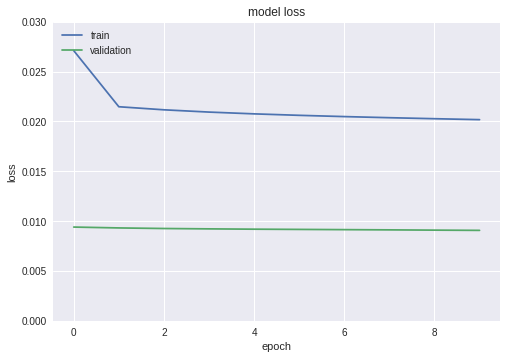

In [ ]:
plot_history(train_history.history['loss'], train_history.history['val_loss'], 0, 0.03)

(330, 1, 1)
(330, 1)


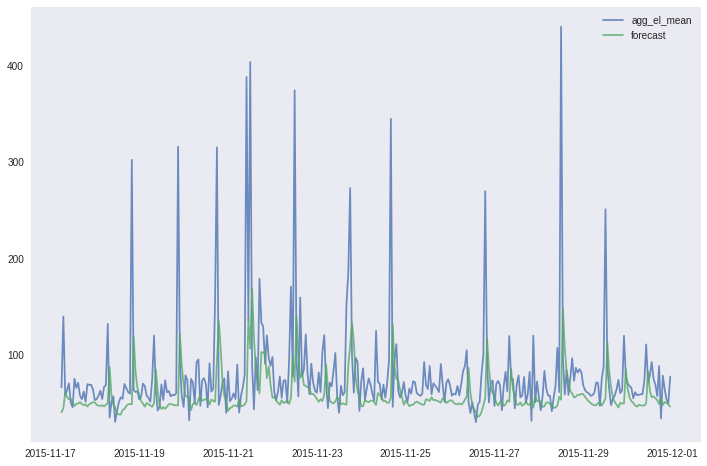

In [ ]:
# Evaluation of prediction performance
print(yhat.shape)

# Output window > 1
#yhat = yhat[0::6].flatten()

yhat = yhat.flatten().reshape((len(yhat),1))
predictions = scaler_train.inverse_transform(yhat)
print(predictions.shape)


plot_test_values(predictions, data_agg, 'agg_el_mean', 'time')

In [ ]:
RMSE_model = calc_rmse(predictions, data_agg, 'agg_el_mean')
print('RMSE:'+str(RMSE_model)) #61

MAE_model = mae(predictions, data_agg, 'agg_el_mean')
BIAS_model = bias(predictions, data_agg, 'agg_el_mean')
print('MAE:'+str(MAE_model)+' and Bias:'+str(BIAS_model)) #31 24

MAPE_model = mape(predictions, data_agg, 'agg_el_mean')
print('MAPE:'+str(MAPE_model)) #31

VO100 = values_over_hund(predictions)
print('VO100: ' + str(VO100))
print('MAX VAL: ' + str(max(predictions)))

RMSE:60.87045140509219
MAE:32.0982747975023 and Bias:20.808332312046225
MAPE:33.00740254515585
VO100: 21
MAX VAL: [169.3339]


# 5. Benchmark Models to Verify Results
To compare the results we get out of our implemented LSTM model we used Persistance model, Autoregressive Integrated Moving Average (ARIMA), Support Vector Machine (SVR) and Pattern sequence based forecasting (PSF) as benchmark models. 

### 5.1. Persistance model for benchmarking
The first benchmark we chose is a naïve model which is based on a persistence model which means that the algorithm uses the value at the previous step to predict the expected outcome at the next step. This model works also as worst-case-scenario and with that as baseline.

In [ ]:
# persistence forecast walk-forward validation
persistence = data_agg['agg_el_mean'][-(len(yhat)+1):-1].to_numpy()
real = data_agg['agg_el_mean'][-len(yhat):].to_numpy()

RMSE_model_0 = np.sqrt(((persistence - real) ** 2).mean()) 
print('RMSE: '+ str(RMSE_model_0))

MAE_model_0 = mae(persistence, data_agg, 'agg_el_mean')
BIAS_model_0 = bias(persistence, data_agg, 'agg_el_mean')
print('MAE:'+str(MAE_model_0)+'and Bias:'+str(BIAS_model_0)) # Optimizing by MAE gives Bias of 32 and MAPE of 33

MAPE_model_0 = mape(persistence, data_agg, 'agg_el_mean')
print('MAPE: ' + str(MAPE_model_0))

RMSE: 70.49439208373965
MAE:34.92156367058319and Bias:0.08589755551018059
MAPE: 40.519457316359365


### 5.2. ARIMA
ARIMA (autoregressive integrated moving average) model is often used as benchmark in the content of time series forecasting because it is flexible and easy to implement. The ARIMA model is an extension of the ARMA model which calculates future values based on a linear function of several observations and errors (Wang et al., 2013). The most significant difference between ARIMA and ARMA is that in ARIMA model the time series gets stationary by transforming, which means that the statistical properties of a process do not change over time. This enables that good predictions can even be done even though there exist for example a trend in the data. So basically what the the ARIMA does differently than ARMA is that it detects trends and any other changes and exclude them out of the time series such that the ARMA algorithm can work again. However, even though the ARIMA model model improve the ARME it is not able to handle nonlinear patterns. 

In [ ]:
# Data selection
dataset = data_agg[[  'agg_el_mean', 'clusters_0', 'clusters_1', 'clusters_2', 'anomaly' ]].copy() # 
print(dataset.head(2))

                     agg_el_mean  clusters_0  clusters_1  clusters_2  anomaly
time                                                                         
2015-08-01 00:00:00    69.978528           0           0           1        0
2015-08-01 01:00:00    43.137039           0           0           1        0


In [ ]:
exog_tr = dataset[['clusters_0', 'clusters_1', 'clusters_2', 'anomaly']].values #

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Model when only using agg_el_mean
#model= SARIMAX(dataset['agg_el_mean'],order=(2, 1, 1),seasonal_order=(1,1,1,12))

model = SARIMAX(dataset['agg_el_mean'], exog=exog_tr, order=(1, 1, 1)) 

model_fit=model.fit()
model_fit.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:            agg_el_mean   No. Observations:                 2928
Model:               SARIMAX(1, 1, 1)   Log Likelihood              -16399.993
Date:                Thu, 25 Mar 2021   AIC                          32813.986
Time:                        17:43:20   BIC                          32855.858
Sample:                    08-01-2015   HQIC                         32829.066
                         - 11-30-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            41.6536   3.25e+04      0.001      0.999   -6.36e+04    6.37e+04
x2            16.1121   3.25e+04      0.000      1.000   -6.36e+04    6.37e+04
x3           -57.7655   3.25e+04     -0.002      0.999   -6.37e+04    6.36e+04
x4             2.9918      3.593      0.833      0.405      -4.050      10.034
ar.L1          0.2563      0.011     22.939      0.000       0.234       0.278
ma.L1         -0.9897      0.003   -394.510      0.000      -0.995      -0.985
sigma2      4268.0317     38.097    112.031      0.000    4193.363    4342.700
===================================================================================
Ljung-Box (Q):                      153.63   Jarque-Bera (JB):            172496.80
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.36   Skew:                             4.33
Prob(H) (two-sided):                  0.00   Kurtosis:                        39.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
 exog = dataset[['clusters_0', 'clusters_1', 'clusters_2', 'anomaly']][2592:2593].values
 exog.shape

(1, 4)

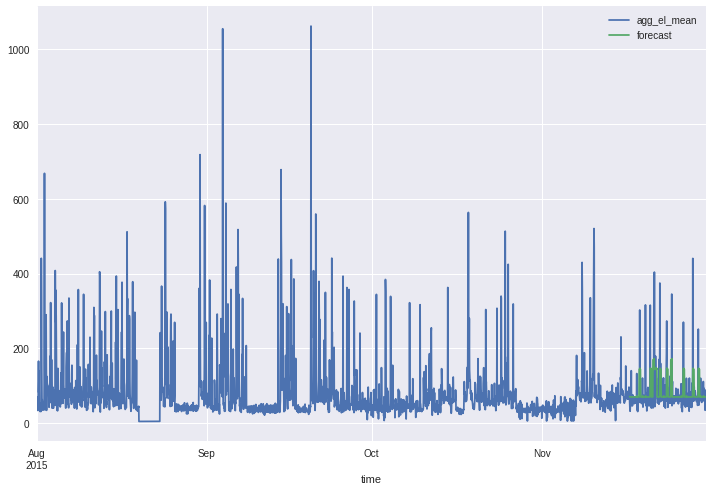

In [ ]:
dataset['forecast']=model_fit.predict(exog=exog, start=2592,end=2928,dynamic=True) #
dataset[['agg_el_mean','forecast']].plot(figsize=(12,8))

According to the Figure it can be seen that the predictions of ARIMA model has a certain baseline which can conclude out from the trend for the specific timer period. Furthermore, it can be seen that the model is not able to predict the peaks in the whole range. It can be observed that they can see when peaks occur but not how much they deviate from the normal behaviour.

In [ ]:
RMSE_ARIMA = calc_rmse(dataset['forecast'], dataset, 'agg_el_mean')
print(RMSE_ARIMA) # simple model: 

MAPE_ARIMA = mape(dataset['forecast'], dataset, 'agg_el_mean')
print(MAPE_ARIMA) 

MAE_model = mae(dataset['forecast'], dataset, 'agg_el_mean')
BIAS_model = bias(dataset['forecast'], dataset, 'agg_el_mean')
print('MAE:'+str(MAE_model)+'and Bias:'+str(BIAS_model)) # Optimizing by MAE gives Bias of 32 and MAPE of 33

VO100 = values_over_hund(dataset['forecast'][2592:2928].values)
print('VO100: ' + str(VO100))
print('MAX VAL: ' + str(max(dataset['forecast'][2592:2928].values)))


51.93547030492091
39.5100193291389
MAE:30.422156290297817and Bias:-6.492749638085159
VO100: 66
MAX VAL: 172.15483241111957


### 5.3 Support Vector Regression (SVR)
Another in the literature often used method is the Support Vector Machine (SVM) which is based on the structural risk minimization principle (Gupta et al. 2019). The main point with this approach is that it can solve nonlinear regression estimation problems by transforming the nonlinear input are into an area with high dimensional properties to find a hyper-plane via nonlinear mapping (Zendehboudi et al., 2018). To approximate the function and regression the support vector regression (SVR) is used. The advantage of SVM methods are that they are more robust against noise and they do not need so much prune to prevent overfitting. 

In [ ]:
# Data selection
dataset = data_agg[[  'agg_el_mean']].copy() #  , 'anomaly' , 'clusters_0', 'clusters_1', 'clusters_2'
print(dataset.head(2))

                     agg_el_mean
time                            
2015-08-01 00:00:00    69.978528
2015-08-01 01:00:00    43.137039


In [ ]:
import matplotlib.dates as mdates

# change the dates into ints for training 
dates_df = dataset.copy()
dates_df = dates_df.reset_index()

# Store the original dates for plotting the predicitons
org_dates = dates_df['time']

# convert to ints
dates_df['time'] = dates_df['time'].map(mdates.date2num)

dates_df.tail()

,time,agg_el_mean
2923,735932.791667,78.637667
2924,735932.833333,64.475155
2925,735932.875000,53.919961
2926,735932.916667,50.281625
2927,735932.958333,77.740946


In [ ]:
train = dates_df[:-336]
test = dates_df[-336:]
print(train.shape)
print(test.shape)

(2592, 2)
(336, 2)


In [ ]:
# implement svm
from sklearn.svm import SVR

dates = train[['time']].values
energy = train['agg_el_mean'].values

test_dates = test[['time']].values

#Convert to 1d Vector
dates = np.reshape(dates, (len(dates), dates.shape[1]))
energy = np.reshape(energy, (len(energy), 1))
test_dates = np.reshape(test_dates, (len(test_dates), dates.shape[1]))

svr_rbf = SVR(kernel= 'rbf', C= 1e3, gamma= 0.1)
svr_rbf.fit(dates, energy)

predictions = svr_rbf.predict(test_dates)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:

RMSE_SVR = calc_rmse(predictions, dataset, 'agg_el_mean')
print(RMSE_SVR) # simple model: 

MAPE_SVR = mape(predictions, dataset, 'agg_el_mean')
print(MAPE_SVR) 

MAE_model = mae(predictions, dataset, 'agg_el_mean')
BIAS_model = bias(predictions, dataset, 'agg_el_mean')
print('MAE:'+str(MAE_model)+'and Bias:'+str(BIAS_model)) # Optimizing by MAE gives Bias of 32 and MAPE of 33

VO100 = values_over_hund(predictions)
print('VO100: ' + str(VO100))
print('MAX VAL: ' + str(max(predictions)))


55.99080671941345
34.091017001513805
MAE:29.58914696290222and Bias:7.536968792871734
VO100: 27
MAX VAL: 102.39350531695932


### 5.4. PSF (Pattern sequence based forecasting)-Algorithm

The PSF Algorithm (Jin et al. 2014) is an algorithm which is able to make forecasts of the behaviour of a time series based on similarities of pattern sequences. 
The algorithm can be divided into two steps: Clustering and Forecasting. 

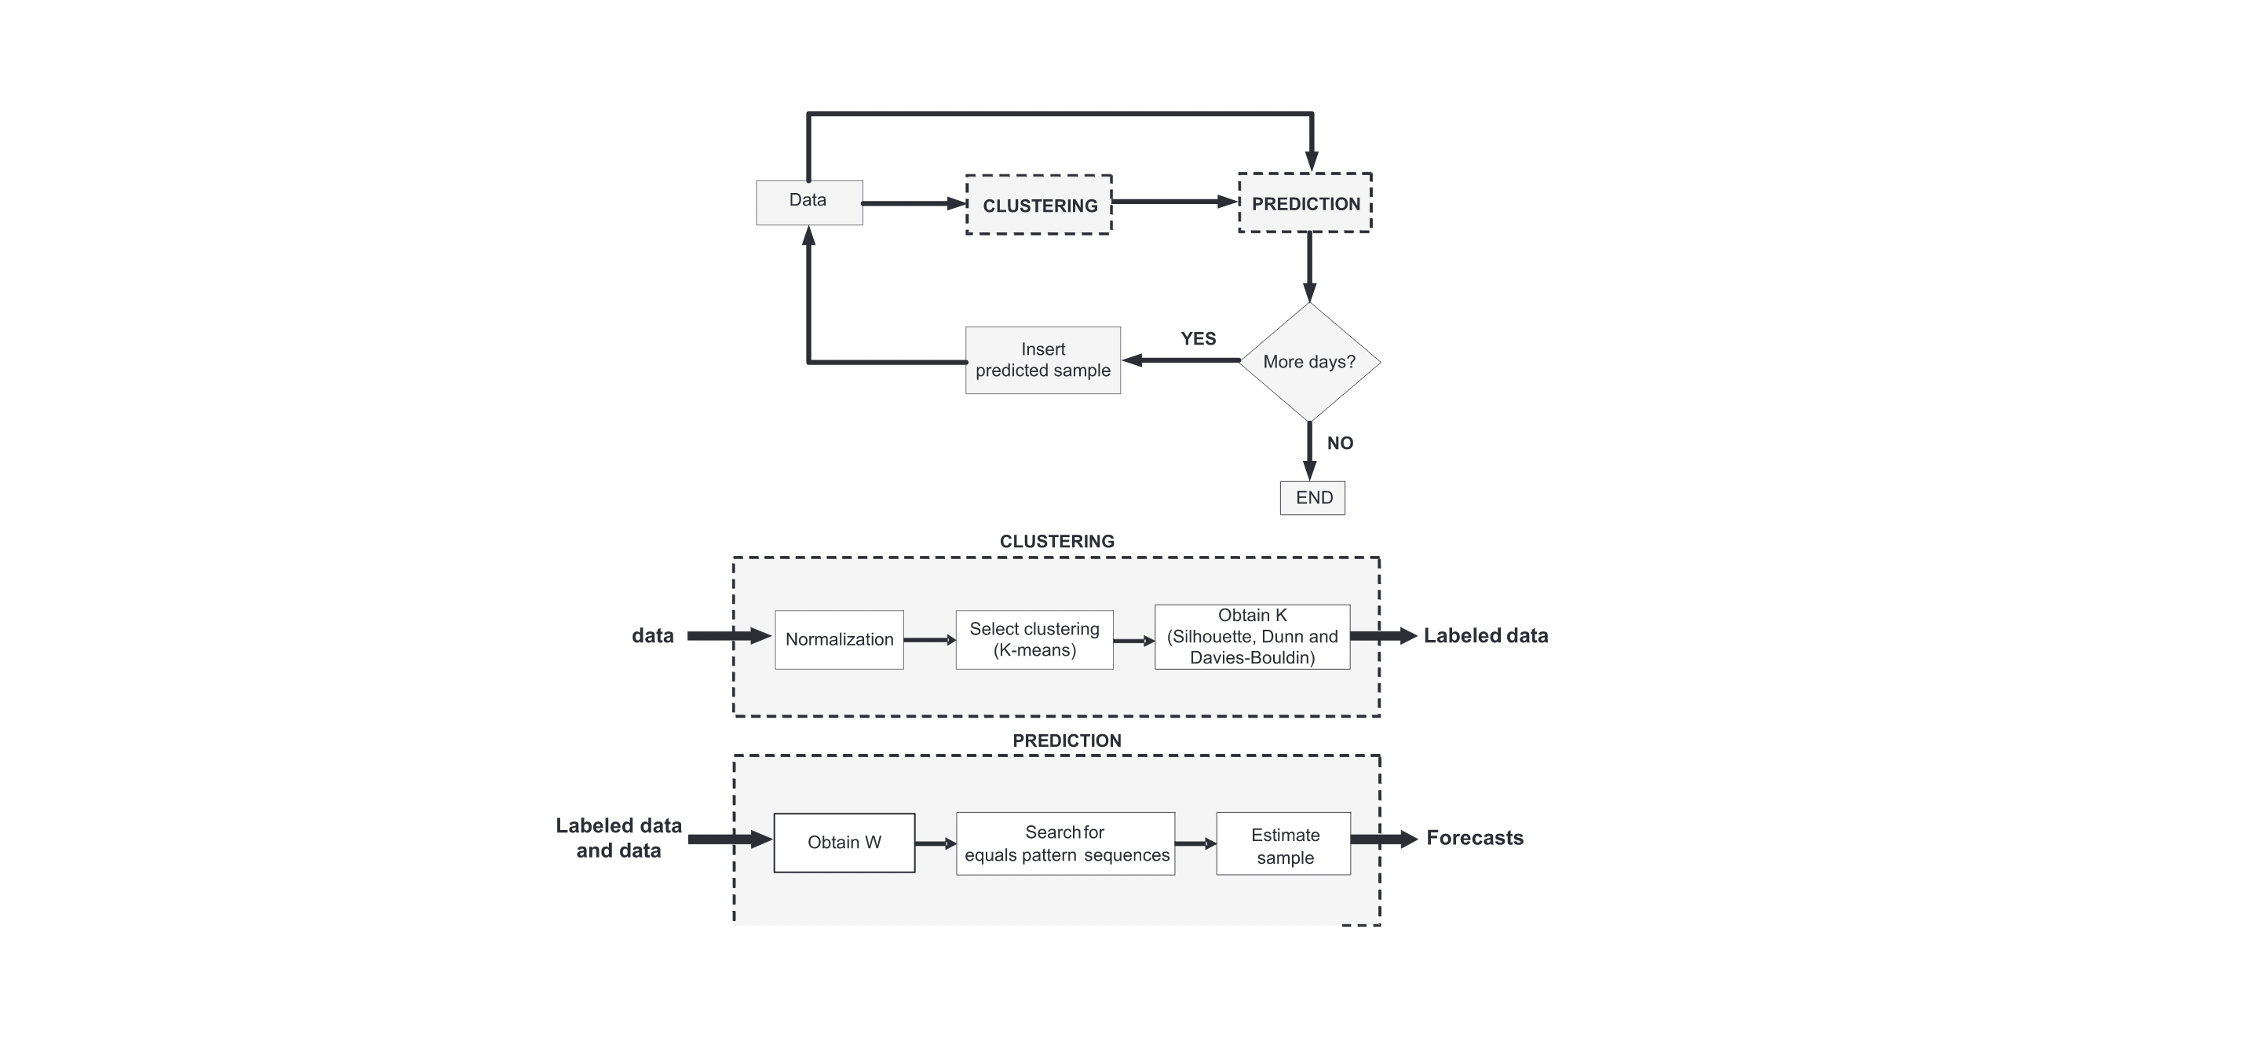

Figure 4.1: Overview PSF-Algorithm

So according the figure it is visible that the data first needs to normalize for the clustering process. Later the clustering algorithm needs to be chosen which is in the python package we use the k-Means clustering. Thereby it is important to find the right number of clusters which can be set with the help of the sihouette function. The silhouette function gives value between -1 and +1 where the goal is to maximize the function. What makes the algorithm different from others is that it uses for the forecast only one dimension, the cluster labels, to predict the energy conusmption. Afterwards a window needed to be obtained which is the observed sequence length for prediction.
Thereby the variable w is choosed by minimizing the forecasting error when the PSF method is applied to a training set. The prediction is executed by finding the sequence length of cluster labels based on the variable w directly before the predicted value. Afterwards, the algorithm seeks for subsequences of labels with the same pattern. The prediction is calculated by the average of the values which comes directly after the subsequence. To predict further values the predicted values are feeded in into the original data and the whole process starts again. 

In [ ]:
!pip install PSF_Py

  Created wheel for PSF-Py: filename=PSF_Py-0.2-cp37-none-any.whl size=6850 sha256=cc1d5ae3a3f5f9c1b8c2e30e962dc32a3edfaaf194311d752b6a11d29e1a6492
  Stored in directory: /root/.cache/pip/wheels/44/17/02/85e916cc297dc0df71dce07a2244fcecaf72a31c46e0a5beaf
Successfully built PSF-Py


In [ ]:
import pandas as pd
from PSF_Py import Psf

def plot(results):
  plt.plot(results['train'])
  plt.plot(results['predict'])
  plt.title('model loss')
  plt.ylabel('time')
  plt.xlabel('energy consumption')
  plt.legend(['train', 'test'], loc='upper left',prop={"size":10})
  plt.show()




In [ ]:
# set of the train and validation dataset
psf_val=full_val
psf_train=full_train.append(psf_val)
psf_train=psf_train.fillna(0)
data_60=psf_train.copy()
data_60['aggregate']=data_60.sum(axis=1)
data_agg_60=data_60[['time','aggregate']]
data_60=data_60.drop(['aggregate'], axis=1)
val=full_test.copy()
val['aggregate']=val.sum(axis=1)
val_agg=val[['time','aggregate']]
val=val.drop(['aggregate'], axis=1)
val_agg
val_agg.index=range(0,336)

In [ ]:
prediction=[]
for i in range(0,int(len(val)/6)):
  data = data_agg_60.append(val_agg[:6*i])
  ts = data['aggregate']
  a = Psf(data = ts,cycle=1)
  #a.predict(n_ahead=6)
  prediction.append(a.predict(n_ahead=6).tolist())


In [ ]:
#loop is needed to make out of  a list consisting of lists only a list
merged_list=[]
for l in prediction:
    merged_list += l

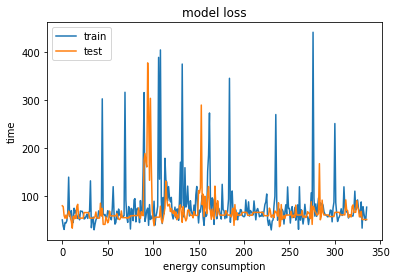

In [ ]:
result_all=pd.DataFrame()
result_all['train']= val_agg['aggregate']
result_all['predict']=merged_list
plot(result_all)

In [ ]:
a=calc_rmse(result_all['predict'],result_all, 'train')
print('RMSE: '+ str(a))
b=mape(result_all['predict'],result_all, 'train')
print('MAPE: '+ str(b))
c=mae(result_all['predict'],result_all, 'train')
print('MAE: '+ str(c))
d=bias(result_all['predict'],result_all, 'train')
print('bias: '+ str(d))

RMSE: 62.081074827578846
MAPE: 32.87098549278157
MAE: 29.49632031491649
bias: 9.803308159145146


In [ ]:
VO100_true = values_over_hund(result_all['predict'])
Max_value_true = max(result_all['predict'])
print('Peak: '+ str(VO100_true))
print('MAX: '+ str(Max_value_true))

Peak: 20
MAX: 376.94823467429376


# References

### Paper


Chahla C., Snoussi H., Merghem L., and Esseghir M. "A Novel Approach for Anomaly Detection in Power Consumption Data", 8th International Conference on Pattern Recognition Applications and Methods (2019): 483-490.

Gupta, D., Pratama, M., Ma, Z., Li, J., & Prasad, M. (2019). Financial time series forecasting usingtwin support vector regression.PLOS ONE,14(3), e0211402. https://doi.org/10.1371/journal.pone.0211402

Jin, C. H., Pok, G., Park, H.-W., & Ryu, K. H. (2014). Improved pattern sequence-based forecastingmethod for electricity load.IEEJ Transactions on Electrical and Electronic Engineering,9(6), 670–674. https://doi.org/10.1002/tee.22024

Wang, L., Zou, H., Su, J., Li, L., & Chaudhry, S. (2013). An ARIMA-ANN Hybrid Model forTime Series Forecasting.Systems Research and Behavioral Science,30(3), 244–259. https://doi.org/10.1002/sres.2179

Zendehboudi, A., Baseer, M., & Saidur, R. (2018). Application of support vector machine modelsfor forecasting solar and wind energy resources: A review.Journal of Cleaner Production,199, 272–285. https://doi.org/10.1016/j.jclepro.2018.07.164

### Blogpost
Angioi, Alessandro. "Time Series Forecasting with an LSTM Encoder/Decoder in TensorFlow 2.0", 01. March 2021. https://www.angioi.com/time-series-encoder-decoder-tensorflow/

Brownlee, Jason. „3 Ways to Encode Categorical Variables for Deep Learning“. Machine Learning Mastery (blog), 21. November 2019. https://machinelearningmastery.com/how-to-prepare-categorical-data-for-deep-learning-in-python/.

„Energy Efficiency | EESI“. Zugegriffen 9. Dezember 2020. https://www.eesi.org/topics/energy-efficiency/description.

Viola, Luciano Guivant. „Clustering Electricity Usage Profiles with K-Means“. Medium, 18. September 2018. https://towardsdatascience.com/clustering-electricity-profiles-with-k-means-42d6d0644d00.
